In [46]:
import h5py
import pandas as pd
import numpy as np
from haversine import haversine
from tqdm import tqdm
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, ElasticNetCV, LassoCV, Lasso
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
nyc_health = pd.read_csv('nychealth.csv')

In [6]:
nyc_health

StateAbbr StateDesc CountyName  CountyFIPS    TractFIPS  TotalPopulation  \
0           NY  New York      Kings       36047  36047009600             6126   
1           NY  New York      Kings       36047  36047011600             4816   
2           NY  New York      Kings       36047  36047046000             3729   
3           NY  New York      Bronx       36005  36005031400             1966   
4           NY  New York      Bronx       36005  36005042300             4100   
...        ...       ...        ...         ...          ...              ...   
2112        NY  New York     Queens       36081  36081113900             3322   
2113        NY  New York      Kings       36047  36047058000             3365   
2114        NY  New York   New York       36061  36061013900             9257   
2115        NY  New York     Queens       36081  36081041400             4033   
2116        NY  New York   New York       36061  36061009800             7316   

      ACCESS2_CrudePrev ACCESS2_Crude95CI  ARTHRITIS_CrudePrev  \
0                  34.5      (29.5, 39.2)                 15.1   
1                  28.0      (23.5, 32.6)                 16.9   
2                  15.0      (12.9, 17.3)                 19.0   
3                  13.8      (11.8, 15.9)                 22.0   
4                  26.7      (22.7, 31.0)                 16.9   
...                 ...               ...                  ...   
2112               13.9      (11.9, 16.0)                 19.7   
2113               16.8      (15.1, 18.5)                 18.3   
2114                7.6      ( 6.4,  9.4)                 17.3   
2115               19.8      (16.8, 23.0)                 20.3   
2116                7.1      ( 5.9,  8.7)                 16.9   

     ARTHRITIS_Crude95CI  ...  closest_transport_nodes_travel_time  \
0           (14.5, 15.7)  ...                                  4.0   
1           (16.2, 17.6)  ...                                  7.0   
2           (18.2, 19.8)  ...                                  9.0   
3           (21.0, 22.9)  ...                                  4.0   
4           (16.3, 17.5)  ...                                  5.0   
...                  ...  ...                                  ...   
2112        (18.9, 20.6)  ...                                  4.0   
2113        (17.7, 18.9)  ...                                  0.0   
2114        (16.5, 18.1)  ...                                  3.0   
2115        (19.4, 21.2)  ...                                  5.0   
2116        (16.3, 17.5)  ...                                  2.0   

     closest_transport_nodes_x  closest_transport_nodes_y  \
0                   -74.008987                  40.649776   
1                   -74.010742                  40.634357   
2                   -73.963348                  40.635517   
3                   -73.846474                  40.858040   
4                   -73.872543                  40.878746   
...                        ...                        ...   
2112                -73.791771                  40.761730   
2113                -73.955475                  40.598938   
2114                -73.982361                  40.767399   
2115                -73.782730                  40.696037   
2116                -73.968521                  40.754875   

     closest_worship_nodes  closest_worship_nodes_travel_time  \
0               42521189.0                                4.0   
1               42486091.0                                7.0   
2               42485802.0                                9.0   
3              470207824.0                                4.0   
4               42739327.0                                5.0   
...                    ...                                ...   
2112            42892953.0                                4.0   
2113            42534874.0                                0.0   
2114            42435716.0                                3.0   
2115           

In [7]:
with h5py.File(r'nearest_EM.hdf5', 'r') as f:
    nodes = f['nodes'][:]
    nodes_x = f['nodes_x'][:]
    nodes_y = f['nodes_y'][:]
    physical_proximity_x = f['closest_physical_nodes_x'][:]
    physical_proximity_y = f['closest_physical_nodes_y'][:]
    transport_proximity_x = f['closest_transport_nodes_x'][:]
    transport_proximity_y = f['closest_transport_nodes_y'][:]
smaller_bounds = (nodes_x > -74.4) & (nodes_x < -73.6) & (nodes_y < 41)
nodes = nodes[smaller_bounds]
nodes_x = nodes_x[smaller_bounds]
nodes_y = nodes_y[smaller_bounds]
physical_proximity_x = physical_proximity_x[smaller_bounds]
physical_proximity_y = physical_proximity_y[smaller_bounds]
transport_proximity_x = transport_proximity_x[smaller_bounds]
transport_proximity_y = transport_proximity_y[smaller_bounds]

In [8]:
def haversine_wrapper(lat1, lon1, lat2, lon2):
    return haversine((lat1, lon1), (lat2, lon2))
physical_dist = np.zeros_like(nodes_x)
transport_dist = np.zeros_like(nodes_x)
for i in tqdm(range(len(nodes_x))):
    physical_dist[i] = haversine_wrapper(nodes_y[i], nodes_x[i], physical_proximity_y[i], physical_proximity_x[i])
    transport_dist[i] = haversine_wrapper(nodes_y[i], nodes_x[i], transport_proximity_y[i], transport_proximity_x[i])
nyc_health['physical_dist'] = np.nan
nyc_health['transport_dist'] = np.nan
num_missed = 0
for i in tqdm(nyc_health.index, total=nyc_health.shape[0]):
    try:
        idx = np.where(nodes == nyc_health.at[i, 'nodes'])[0][0]
        nyc_health.at[i, 'physical_dist'] = physical_dist[idx]
        nyc_health.at[i, 'transport_dist'] = transport_dist[idx]
    except IndexError:
        num_missed += 1
print('Missed:', num_missed)

100%|████████████████████████████████████| 2117/2117 [00:00<00:00, 44013.35it/s]

Missed: 0


In [38]:
nyc_health.to_csv('nychealth_w_desert_measures.csv', index=False)

In [34]:
name_mapping = {'access2': 'Health insurance access', 'arthritis': 'Arthritis prevalence', 'binge': 'Binge drinking prevalence',
               'bphigh': 'High blood pressure prevalence', 'bpmed': 'Medium blood pressure prevalence', 'cancer': 'Cancer prevalence',
               'casthma': 'Asthma prevalence', 'cervical': 'Cervical cancer screenings', 'chd': 'Coronary heart disease prevalence',
               'checkup': 'Routine checkups', 'cholscreen': 'Cholesterol screenings', 'colon_screen': 'Colon cancer screenings',
               'copd': 'COPD prevalence', 'corem': 'Core men\'s health', 'corew': 'Core women\'s health', 'csmoking': 'Smoking prevalence',
               'dental': 'Dental checkups', 'depression': 'Depression prevalence', 'diabetes': 'Diabetes prevalence', 'ghlth': 'General poor health prevalence',
               'highchol': 'High cholesterol prevalence', 'kidney': 'Chronic kidney disease', 'lpa': 'No physical activity', 'mammouse': 'Mammograms',
               'mhlth': 'Poor mental health prevalence', 'obesity': 'Obesity prevalence', 'phlth': 'Poor physical health', 'sleep': 'Poor sleep prevalence',
               'stroke': 'Stroke prevalence', 'teethlost': 'Teeth loss prevalence'}
X = np.array([nyc_health['closest_education_nodes_travel_time'].to_numpy(), nyc_health['closest_food_nodes_travel_time'],
             nyc_health['closest_worship_nodes_travel_time'], nyc_health['physical_dist'], nyc_health['transport_dist']]).T
results_nan = pd.DataFrame({'Health condition': [np.nan for c in nyc_health.columns if c.endswith('CrudePrev')], 'Food': [np.nan for c in nyc_health.columns if c.endswith('CrudePrev')],
                       'Physical health': [np.nan for c in nyc_health.columns if c.endswith('CrudePrev')], 'Public transport': [np.nan for c in nyc_health.columns if c.endswith('CrudePrev')],
                        'Education': [np.nan for c in nyc_health.columns if c.endswith('CrudePrev')], 'Houses of worship': [np.nan for c in nyc_health.columns if c.endswith('CrudePrev')],
                       'RSquared': [np.nan for c in nyc_health.columns if c.endswith('CrudePrev')], 'MSE': [np.nan for c in nyc_health.columns if c.endswith('CrudePrev')]})
nyc_health = nyc_health[(~np.isnan(X)).all(axis=1)]
X = X[(~np.isnan(X)).all(axis=1)]

In [71]:
health_cols = list(name_mapping.keys())
desert_measures = ['closest_education_nodes_travel_time','closest_food_nodes_travel_time',
                   'closest_worship_nodes_travel_time', 'physical_dist', 'transport_dist']
name_mapping.keys()

dict_keys(['access2', 'arthritis', 'binge', 'bphigh', 'bpmed', 'cancer', 'casthma', 'cervical', 'chd', 'checkup', 'cholscreen', 'colon_screen', 'copd', 'corem', 'corew', 'csmoking', 'dental', 'depression', 'diabetes', 'ghlth', 'highchol', 'kidney', 'lpa', 'mammouse', 'mhlth', 'obesity', 'phlth', 'sleep', 'stroke', 'teethlost'])

In [42]:
def update_results(results, model, i, X_test, y_test, name):
    results.iat[i, 0] = name
    results.iat[i, 1] = model.coef_[1]
    results.iat[i, 2] = model.coef_[3]
    results.iat[i, 3] = model.coef_[4]
    results.iat[i, 4] = model.coef_[0]
    results.iat[i, 5] = model.coef_[2]
    #results.iat[i, 6] = model.score(X_test, y_test)

In [12]:
def make_resid_plot(predictions, X_test, y_test, name, i):
    ax = plt.subplot(6, 5, i + 1)
    sns.residplot(predictions, y_test, lowess=True, 
                      line_kws={'color': 'red', 'lw': 1, 'alpha': 1}, ax=ax)
    ax.set_xlabel("Fitted values")
    ax.set_ylabel("Observed values")
    ax.set_title(name)

In [13]:
def make_qq_plot(residuals, X_test, y_test, name, i):
    ax = plt.subplot(6, 5, i + 1)
    stats.probplot(residuals, dist="norm", plot=ax)
    plt.title(name)

In [14]:
def make_htsk_plot(residuals, predictions, name, i):
    ax = plt.subplot(6, 5, i + 1)
    model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

    sns.regplot(predictions, model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)
    ax.set_ylabel("Standarized residuals")
    ax.set_xlabel("Fitted value")
    ax.set_title(name)

In [15]:
def layout_resid_plot():
    plt.suptitle("Elastic Net Residual Plots", fontsize=18, y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

def layout_qq_plot():
    plt.suptitle("Elastic Net Q-Q Plots", fontsize=18, y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

def layout_htsk_plot():
    plt.suptitle("Elastic Net Heteroskedacity Plots", fontsize=18, y=0.95)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


In [51]:
alphas = []
l1_ratios = []
i=0
results = results_nan.copy()

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)

for c in nyc_health.columns:
    if c.endswith('CrudePrev'):
        name = name_mapping[c[:-10].lower()]
        
        x = X.copy()
        scaler = preprocessing.StandardScaler()
        xscale = scaler.fit_transform(x)
        y = nyc_health[c].to_numpy(copy=True)
        xscale = xscale[~np.isnan(y)]
        y = y[~np.isnan(y)]
        #create function to center data
        center_function = lambda x: x - x.mean()

        #apply function to original NumPy array
        y = center_function(y)
        
        X_train, X_test, y_train, y_test = train_test_split(xscale, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)
        
        #l1 ratio is from suggested values in ElasticNetCV documentation
        lasso_cv = LassoCV(cv = 5, normalize=True).fit(X_train,y_train)
        
        alpha = lasso_cv.alpha_
        alphas.append(alpha)
        
        regr = Lasso(alpha=alpha, normalize=True)  # Could try others, or other parameters?
        regr.fit(X_train, y_train.reshape(-1, 1))
        
        update_results(results, regr, i, X_test, y_test, name)
        
        predictions = regr.predict(X_test)
        y_train_pred = regr.predict(X_train)
        mse_train = mean_squared_error(y_train, y_train_pred)
        results.iat[i,6] = r2_score(y_train, y_train_pred)
        results.iat[i, 7] = mse_train
        #make_resid_plot(predictions, X_test, y_test, name, i)
        
        #residuals = y_test - predictions
        #make_qq_plot(residuals, X_test, y_test, name, i)
        #make_htsk_plot(residuals, predictions, name, i)
            
        i += 1

#layout_resid_plot()
#plt.savefig('plots/all_deserts/elasticnet_resid.png', transparent=False, dpi=300)
results

Health condition      Food  Physical health  \
0             Health insurance access  0.555227        -0.505069   
1                Arthritis prevalence  0.843995        -0.237822   
2           Binge drinking prevalence -0.701987        -0.141495   
3      High blood pressure prevalence  1.354894        -0.299906   
4    Medium blood pressure prevalence  0.707434         0.042993   
5                   Cancer prevalence  0.100765         0.000000   
6                   Asthma prevalence  0.350021        -0.203965   
7          Cervical cancer screenings  0.340787         0.242357   
8   Coronary heart disease prevalence  0.248196        -0.162935   
9                    Routine checkups  0.647903         0.139708   
10             Cholesterol screenings  0.000000         0.223191   
11            Colon cancer screenings -0.473709         0.323421   
12                    COPD prevalence  0.325760        -0.172266   
13                  Core men's health -0.316102         0.340939   
14                Core women's health  0.000000         0.200122   
15                 Smoking prevalence  0.728325        -0.328560   
16                    Dental checkups -1.058629         0.570249   
17              Depression prevalence -0.006285        -0.339916   
18                Diabetes prevalence  0.612434        -0.236160   
19     General poor health prevalence  1.151108        -0.794934   
20        High cholesterol prevalence  0.432669        -0.030274   
21             Chronic kidney disease  0.112042        -0.107045   
22               No physical activity  1.543355        -0.470967   
23                         Mammograms -0.101590        -0.297572   
24      Poor mental health prevalence  0.399491        -0.306645   
25                 Obesity prevalence  1.626065        -0.184183   
26               Poor physical health  0.551603        -0.380542   
27              Poor sleep prevalence  0.623760         0.000000   
28                  Stroke prevalence  0.179106        -0.111552   
29              Teeth loss prevalence  0.785011        -0.840840   

    Public transport     Education  Houses of worship  RSquared         MSE  
0          -0.327829 -5.584214e-01      -2.107716e-01  0.024511   53.313557  
1           0.697413 -0.000000e+00      -1.914816e-01  0.083977   14.062210  
2          -0.792365  1.548358e-01       2.416671e-01  0.066556   12.940630  
3           0.814812 -2.701682e-02      -4.490633e-01  0.060985   36.132411  
4           0.698341 -0.000000e+00      -0.000000e+00  0.055227   24.818624  
5           0.279465  0.000000e+00       0.000000e+00  0.055034    2.287210  
6          -0.000000 -0.000000e+00      -1.046267e-01  0.055299    2.673043  
7           0.000000  3.921366e-01       0.000000e+00  0.021781   22.836533  
8           0.206427 -3.049018e-02      -9.053675e-02  0.033882    3.059496  
9           0.424354  0.000000e+00       0.000000e+00  0.077220   10.195819  
10          0.181993  2.170160e-01       3.340882e-17  0.029001    9.567478  
11          0.000000  4.366988e-01       1.798264e-01  0.011705   53.012438  
12          0.280445 -7.632493e-02      -1.117158e-01  0.042805    3.702527  
13         -0.262063  4.526176e-01       1.195117e-01  0.011363   22.031735  
14          0.000000  4.548079e-01       0.000000e+00  0.021597   14.722129  
15          0.278515 -1.394151e-01      -2.564108e-01  0.038781   14.894091  
16          0.000000  6.532377e-01       4.018699e-01  0.019210  102.030696  
17         -0.183990 -0.000000e+00      -0.000000e+00  0.036563    5.170698  
18          0.000000 -2.514669e-05      -9.723011e-02  0.033906   13.054370  
19         -0.000000 -2.623772e-01      -4.369762e-01  0.034716   56.919165  
20          0.332769  0.000000e+00       0.000000e+00  0.031172   14.045347  
21          0.000000 -1.049598e-06      -1.705768e-02  0.034153    0.769172  
22          0.562799 -3.841490e-01      -5.723368e-01  0.033837   67.851534  
23         -0.260189 -3.980610e-03      

<Figure size 1440x1080 with 0 Axes>

Health condition      Food  Physical health  \
0             Health insurance access  0.430879        -0.424881   
1                Arthritis prevalence  0.777657        -0.203346   
2           Binge drinking prevalence -0.690745        -0.141480   
3      High blood pressure prevalence  1.294933        -0.285861   
4    Medium blood pressure prevalence  0.697213         0.071021   
5                   Cancer prevalence  0.096605         0.000000   
6                   Asthma prevalence  0.348682        -0.203304   
7          Cervical cancer screenings  0.339888         0.241103   
8   Coronary heart disease prevalence  0.234523        -0.154946   
9                    Routine checkups  0.647216         0.138849   
10             Cholesterol screenings  0.000000         0.226151   
11            Colon cancer screenings -0.445826         0.314353   
12                    COPD prevalence  0.317916        -0.168798   
13                  Core men's health -0.239769         0.285249   
14                Core women's health  0.000000         0.216234   
15                 Smoking prevalence  0.691230        -0.315574   
16                    Dental checkups -1.068127         0.575960   
17              Depression prevalence -0.017708        -0.354211   
18                Diabetes prevalence  0.596497        -0.245372   
19     General poor health prevalence  1.160068        -0.801157   
20        High cholesterol prevalence  0.376808        -0.053799   
21             Chronic kidney disease  0.117210        -0.108928   
22               No physical activity  1.449278        -0.447769   
23                         Mammograms -0.097726        -0.292266   
24      Poor mental health prevalence  0.400443        -0.307293   
25                 Obesity prevalence  1.626065        -0.184183   
26               Poor physical health  0.559417        -0.388316   
27              Poor sleep prevalence  0.815371         0.000000   
28                  Stroke prevalence  0.165958        -0.104417   
29              Teeth loss prevalence  0.746181        -0.812493   

    Public transport  Education  Houses of worship  RSquared  
0          -0.321040  -0.335254          -0.335261  0.017815  
1           0.502894   0.000000           0.000000  0.078180  
2          -0.743353   0.173612           0.174425  0.020676  
3           0.676509  -0.163569          -0.164281  0.042508  
4           0.689215   0.000000           0.000000  0.038320  
5           0.275218   0.000000           0.000000  0.044978  
6          -0.000000  -0.046360          -0.057619  0.047917  
7           0.000000   0.391256           0.000000  0.020280  
8           0.164787  -0.039088          -0.039162  0.013487  
9           0.423678   0.000000           0.000000  0.052833  
10          0.167397   0.123092           0.123191  0.006991  
11          0.000000   0.300011           0.299595 -0.003263  
12          0.254950  -0.080954          -0.081173  0.024893  
13         -0.064784   0.170075           0.170108  0.003257  
14         -0.000000   0.236410           0.234155 -0.001944  
15          0.229134  -0.167667          -0.167867  0.019874  
16          0.000000   0.658748           0.405475  0.000035  
17         -0.195254  -0.000000          -0.000000  0.012526  
18          0.080369  -0.092819          -0.092867  0.013767  
19         -0.000000  -0.350137          -0.362938  0.014164  
20          0.222907   0.068188           0.068192  0.020927  
21          0.025652  -0.024593          -0.024619  0.024215  
22          0.417760  -0.389908          -0.390188  0.005755  
23         -0.257086  -0.003021          -0.000000  0.012026  
24         -0.000000  -0.125858          -0.127767  0.014415  
25          0.000000  -0.000000          -0.000000  0.066617  
26          0.103516  -0.143390          -0.143578  0.016886  
27          0.335639  -0.194606          -0.211536  0.016754  
28          0.075544  -0.032713          -0.032741  0.018633  
29          0.433725  

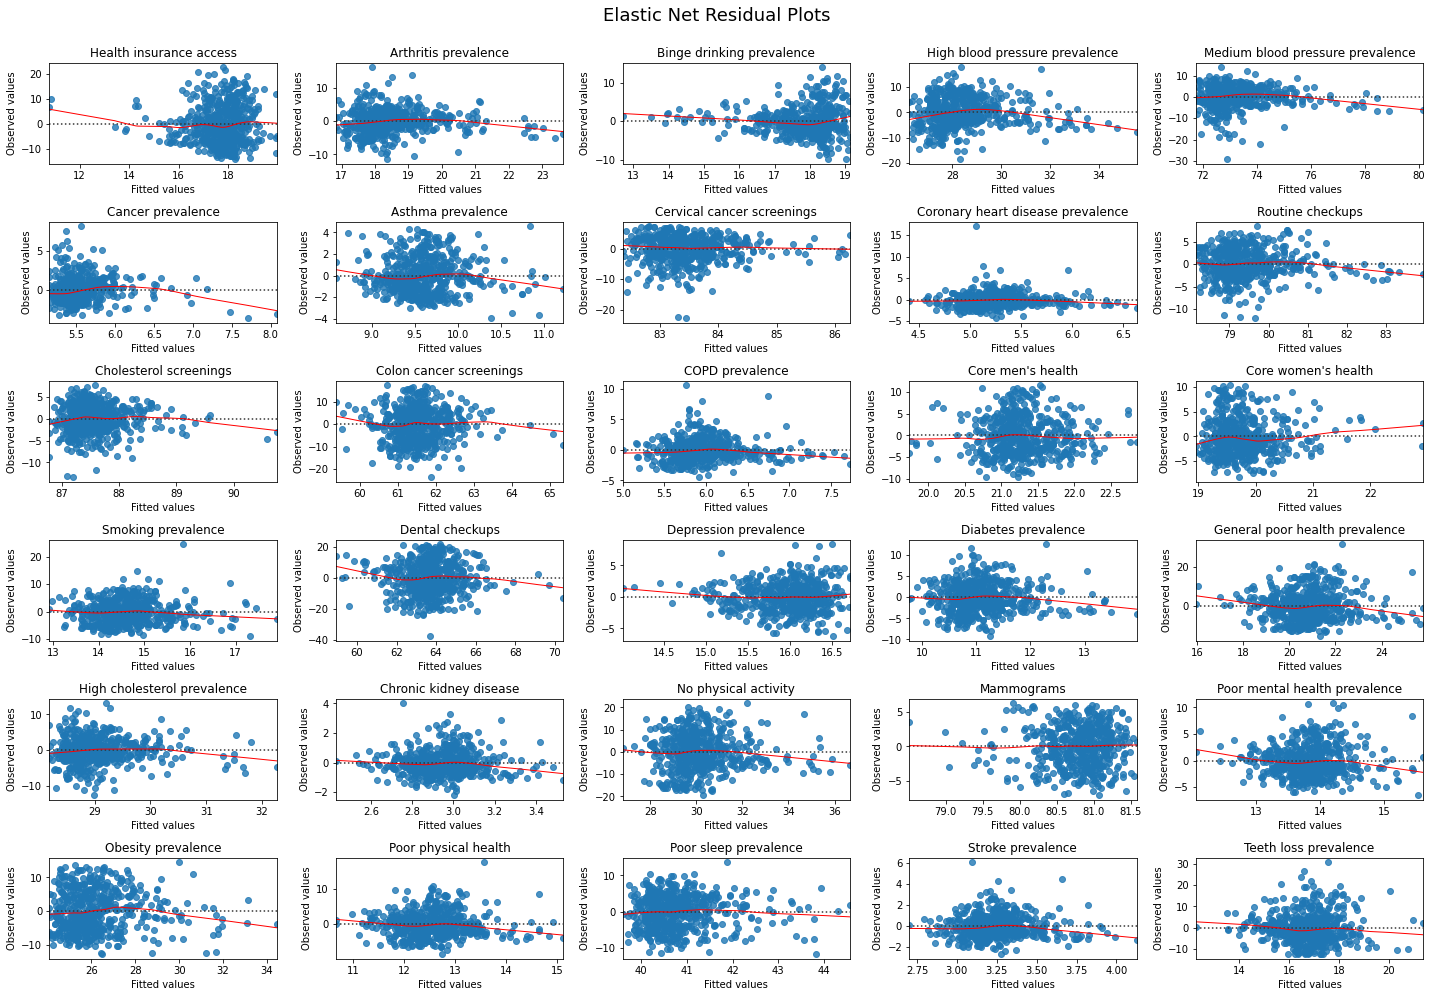

In [29]:
alphas = []
l1_ratios = []
i=0
results = results_nan.copy()

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)

for c in nyc_health.columns:
    if c.endswith('CrudePrev'):
        name = name_mapping[c[:-10].lower()]
        
        x = X.copy()
        scaler = preprocessing.StandardScaler()
        xscale = scaler.fit_transform(x)
        y = nyc_health[c].to_numpy(copy=True)
        xscale = xscale[~np.isnan(y)]
        y = y[~np.isnan(y)]
        #create function to center data
        center_function = lambda x: x - x.mean()

        #apply function to original NumPy array
        data_centered = center_function(y)
        
        X_train, X_test, y_train, y_test = train_test_split(xscale, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)
        
        #l1 ratio is from suggested values in ElasticNetCV documentation
        enet_cv = ElasticNetCV(l1_ratio = [.1, .2, .4, .5, .7, .9, .95, .99, 1], 
                                     cv = 10, normalize=True).fit(X_train,y_train)
        
        alpha = enet_cv.alpha_
        l1 = enet_cv.l1_ratio_
        alphas.append(alpha)
        l1_ratios.append(l1)
        
        regr = ElasticNet(alpha=alpha, l1_ratio = l1, normalize=True)  # Could try others, or other parameters?
        regr.fit(X_train, y_train.reshape(-1, 1))
        
        update_results(results, regr, i, X_test, y_test, name)
        
        predictions = regr.predict(X_test)
        make_resid_plot(predictions, X_test, y_test, name, i)
        
        #residuals = y_test - predictions
        #make_qq_plot(residuals, X_test, y_test, name, i)
        #make_htsk_plot(residuals, predictions, name, i)
            
        i += 1

layout_resid_plot()
plt.savefig('plots/all_deserts/elasticnet_resid.png', transparent=False, dpi=300)
results

Health condition    Food  Physical health  \
0             Health insurance access  0.7937          -0.5055   
1                Arthritis prevalence  0.7905          -0.2407   
2           Binge drinking prevalence -0.7417          -0.0000   
3      High blood pressure prevalence  1.5876          -0.3758   
4    Medium blood pressure prevalence  0.7769           0.0000   
5                   Cancer prevalence  0.0394           0.0000   
6                   Asthma prevalence  0.4169          -0.2468   
7          Cervical cancer screenings  0.2237           0.2057   
8   Coronary heart disease prevalence  0.2508          -0.1557   
9                    Routine checkups  0.6969           0.1009   
10             Cholesterol screenings  0.0061           0.2677   
11            Colon cancer screenings -0.5945           0.3821   
12                    COPD prevalence  0.3537          -0.1889   
13                  Core men's health -0.3439           0.2869   
14                Core women's health -0.1770           0.2785   
15                 Smoking prevalence  0.7714          -0.3682   
16                    Dental checkups -1.4407           0.6463   
17              Depression prevalence -0.0988          -0.3325   
18                Diabetes prevalence  0.7872          -0.2671   
19     General poor health prevalence  1.4472          -0.8922   
20        High cholesterol prevalence  0.3998          -0.0589   
21             Chronic kidney disease  0.1588          -0.1168   
22               No physical activity  1.8254          -0.5558   
23                         Mammograms -0.0774          -0.2272   
24      Poor mental health prevalence  0.5100          -0.3744   
25                 Obesity prevalence  1.9529          -0.3576   
26               Poor physical health  0.6883          -0.4477   
27              Poor sleep prevalence  0.8735          -0.0000   
28                  Stroke prevalence  0.2172          -0.1112   
29              Teeth loss prevalence  1.0138          -0.9263   

    Public transport  Education  Houses of worship  RSquared         MSE  
0            -0.9879     0.0000           0.000000    0.0262   57.537750  
1             0.6163    -0.0000          -0.000000    0.0734   14.240728  
2            -0.4176    -0.0000          -0.000000    0.0387   13.024331  
3             0.4265     0.0775           0.074783    0.0542   35.414996  
4             0.7991     0.0000           0.000000    0.0514   25.783153  
5             0.3293     0.0000           0.000000    0.0436    2.579425  
6            -0.0591    -0.0144          -0.017549    0.0401    2.784316  
7             0.2230     0.0789           0.078924    0.0133   19.366196  
8             0.1428     0.0000           0.000000    0.0224    4.103797  
9             0.4583     0.0000           0.000000    0.0521   10.262809  
10            0.4344     0.0120           0.012593    0.0165   10.407788  
11            0.4994    -0.0000          -0.000000    0.0038   56.589080  
12            0.1593     0.0000           0.000000    0.0352    4.009555  
13            0.1638     0.0381           0.038097    0.0105   20.200306  
14            0.2997     0.0000           0.000000    0.0088   13.514125  
15           -0.0000    -0.0000          -0.000000    0.0227   16.744318  
16            0.8501    -0.0000          -0.000000    0.0080  109.188658  
17           -0.1009    -0.0639          -0.064041    0.0195    5.133239  
18           -0.0000     0.0000           0.000000    0.0237   13.935764  
19           -0.5484     0.0000           0.000000    0.0271   60.856368  
20            0.4117     0.0000           0.000000    0.0220   14.024341  
21            0.0000     0.0005           0.000144    0.0341    0.840484  
22           -0.1761     0.0000           0.000000    0.0165   71.444210  
23           -0.1307    -0.0646          -0.064613    0.0090    8.676743  
24           -0.2181    -0.0000          -0.000000    0.0172    8.494870  
25           -0.0000    

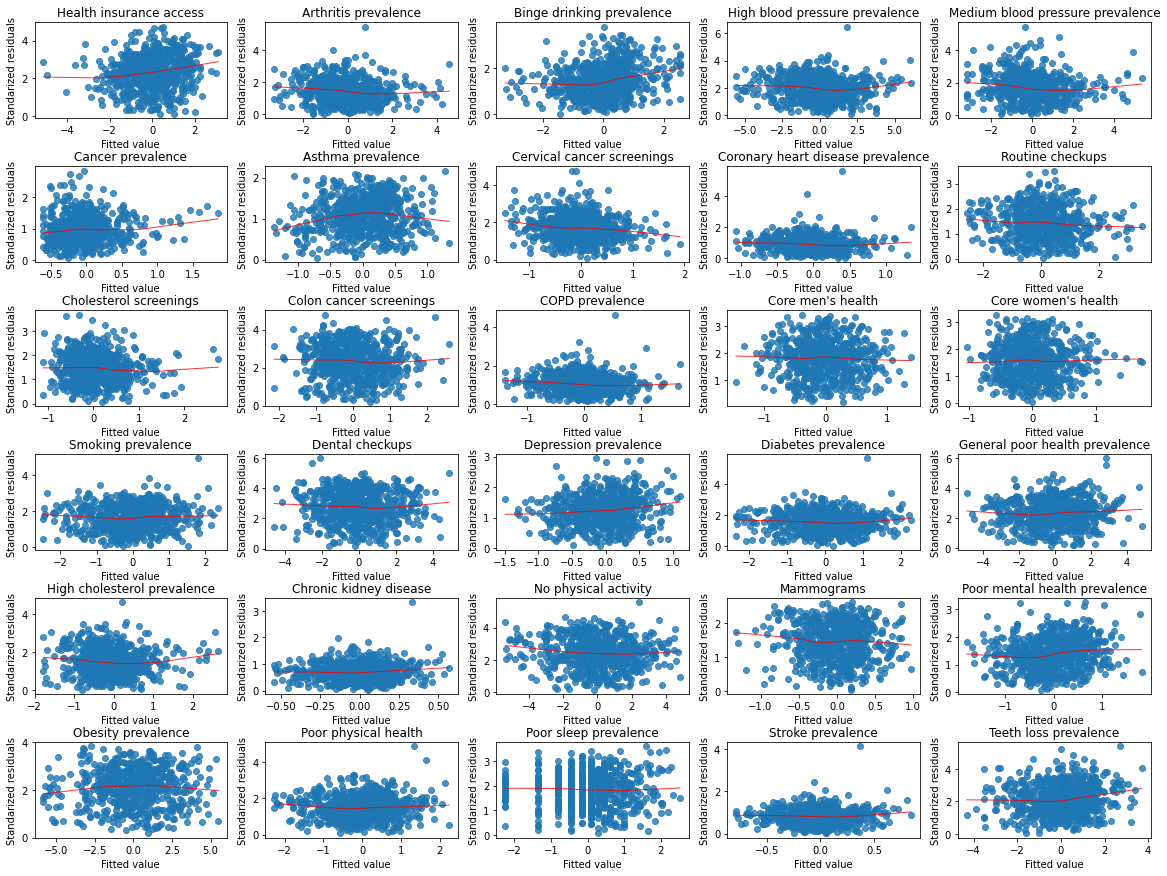

In [52]:
alphas = []
l1_ratios = []
i=0
results = results_nan.copy()

plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)

for c in nyc_health.columns:
    if c.endswith('CrudePrev'):
        name = name_mapping[c[:-10].lower()]
        
        x = np.log(X.copy()+1)
        scaler = preprocessing.StandardScaler()
        xscale = scaler.fit_transform(x)
        y = nyc_health[c].to_numpy(copy=True)
        xscale = xscale[~np.isnan(y)]
        y = y[~np.isnan(y)]
        #create function to center data
        center_function = lambda x: x - x.mean()

        #apply function to original NumPy array
        y = center_function(y)
        
        X_train, X_test, y_train, y_test = train_test_split(xscale, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)
        
        #l1 ratio is from suggested values in ElasticNetCV documentation
        enet_cv = ElasticNetCV(l1_ratio = [.1, .2, .4, .5, .7, .9, .95, .99, 1], 
                                     cv = 10, normalize=True).fit(X_train,y_train)
        
        alpha = enet_cv.alpha_
        l1 = enet_cv.l1_ratio_
        alphas.append(alpha)
        l1_ratios.append(l1)
        
        regr = ElasticNet(alpha=alpha, l1_ratio = l1, normalize=True)  # Could try others, or other parameters?
        regr.fit(X_train, y_train.reshape(-1, 1))
        
        update_results(results, regr, i, X_test, y_test, name)
        
        predictions = regr.predict(X_test)
        predictions = regr.predict(X_test)
        y_train_pred = regr.predict(X_train)
        mse_train = mean_squared_error(y_test, predictions)
        results.iat[i,6] = r2_score(y_test, predictions)
        results.iat[i, 7] = mse_train
        #make_resid_plot(predictions, X_test, y_test, name, i)
        
        residuals = y_test - predictions
        #make_qq_plot(residuals, X_test, y_test, name, i)
        make_htsk_plot(residuals, predictions, name, i)
            
        i += 1

#layout_resid_plot()
#layout_qq_plot()
#layout_htsk_plot()
#plt.show()
#plt.savefig('plots/all_deserts/elasticnet_log_htsk.png', transparent=False, dpi=300)

results_round = results.round({'Food': 4, 'Physical health':4, 'Public transport':4, 'Education':4,
             'House of worship':4, 'RSquared':4})
results_round
#results_round.to_csv(r'elasticnet_log_alldeserts.csv', index=False)

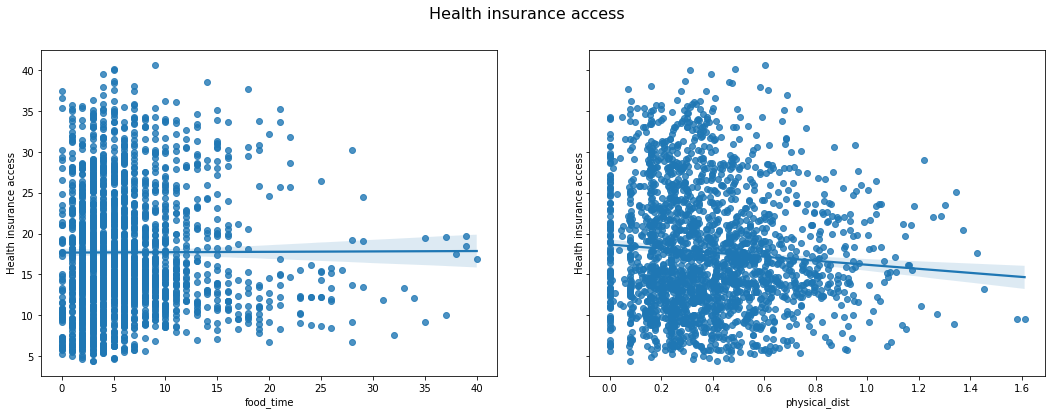

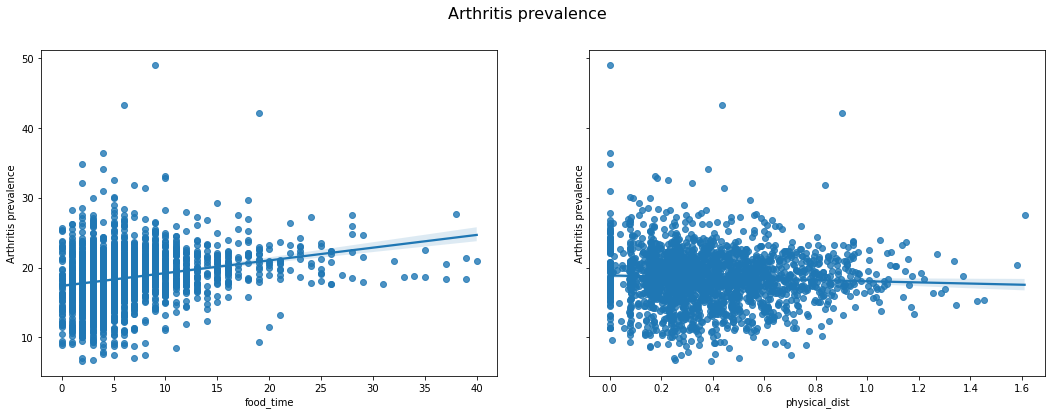

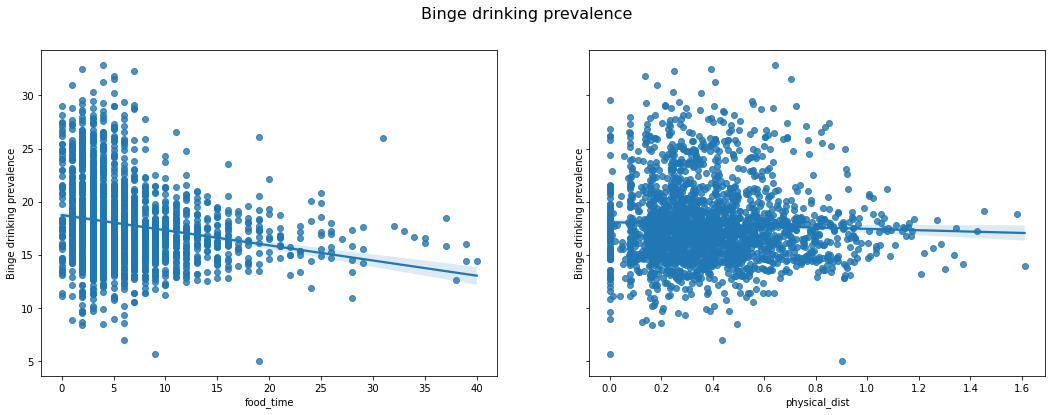

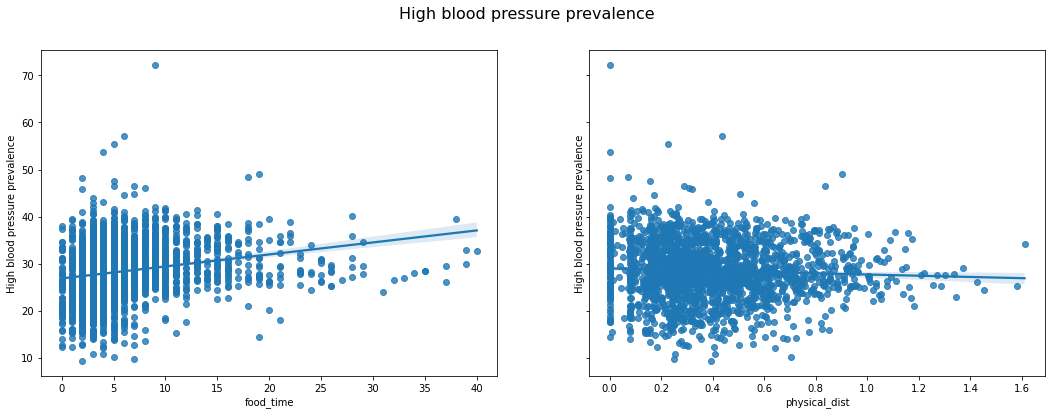

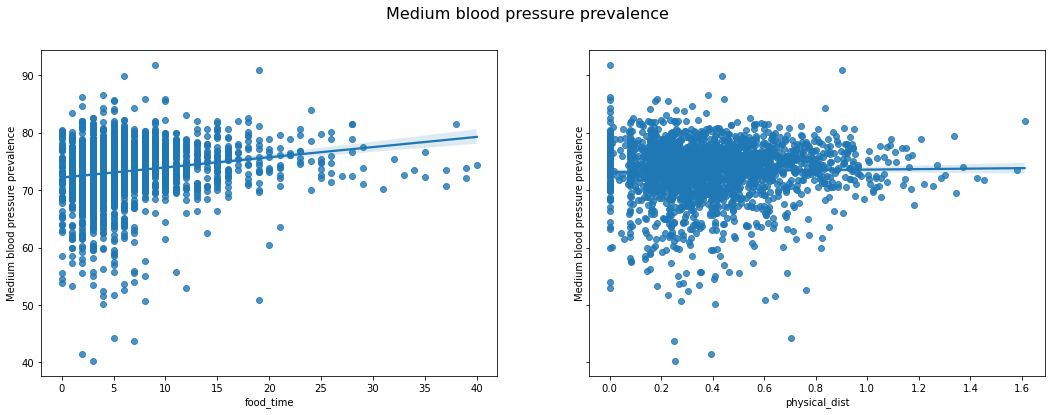

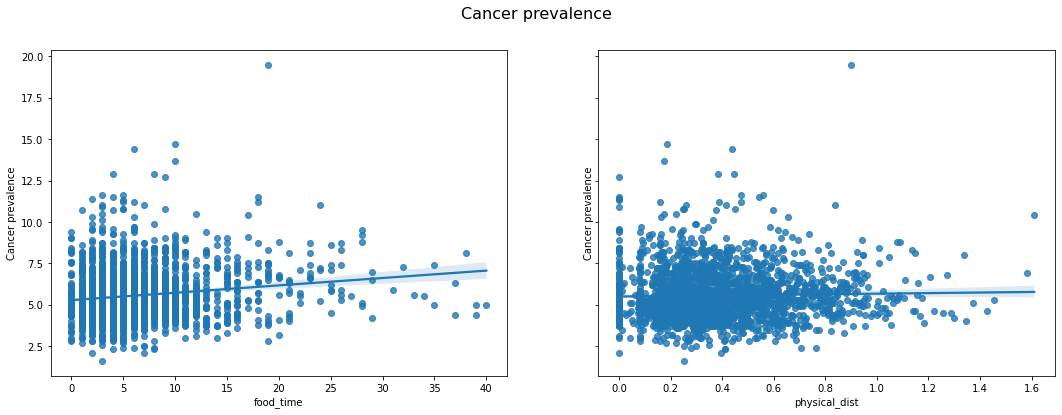

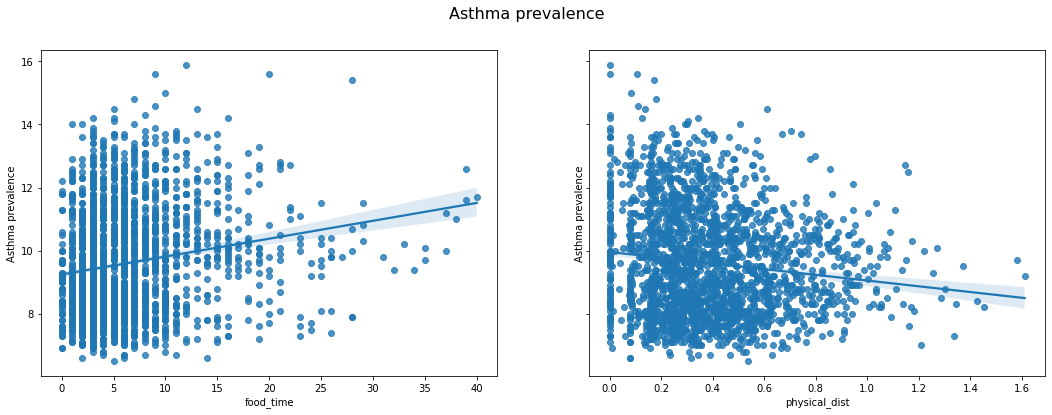

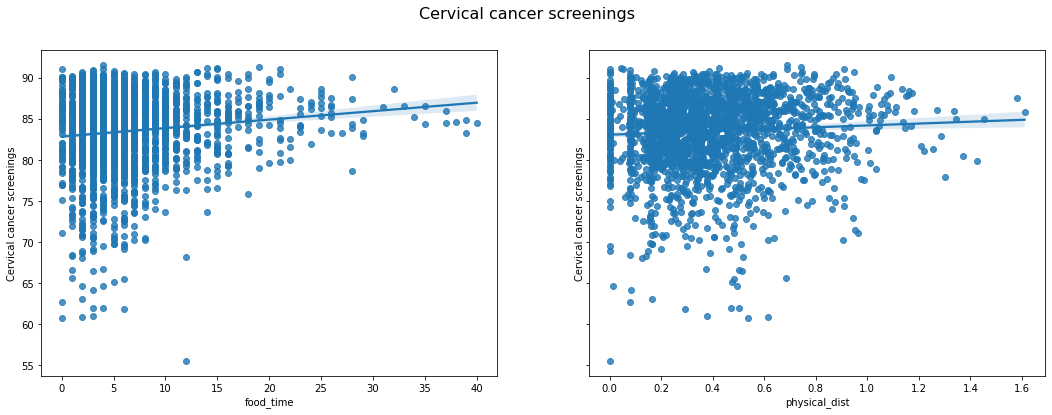

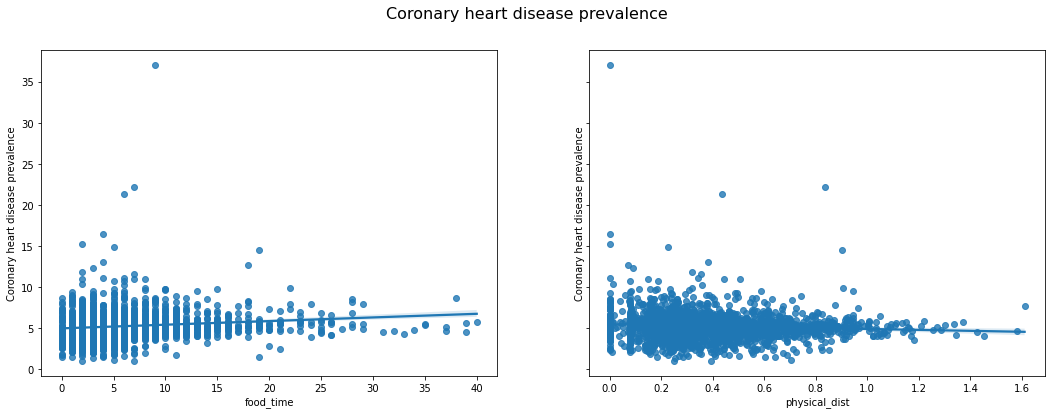

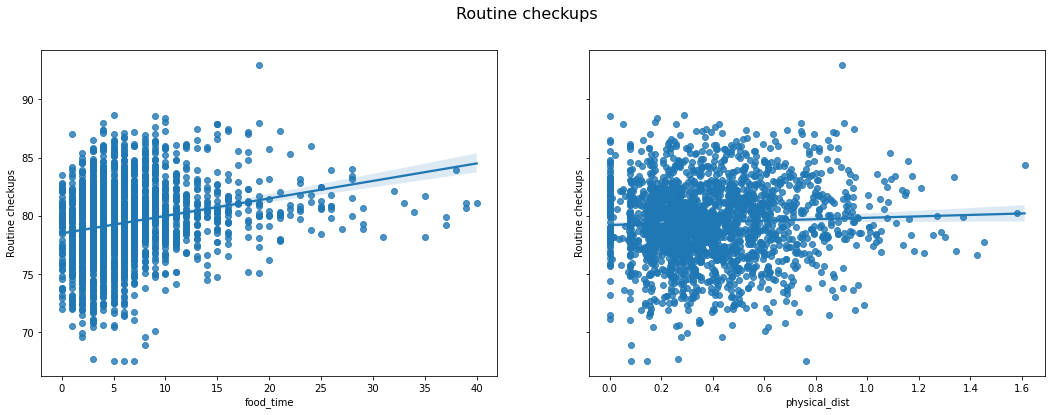

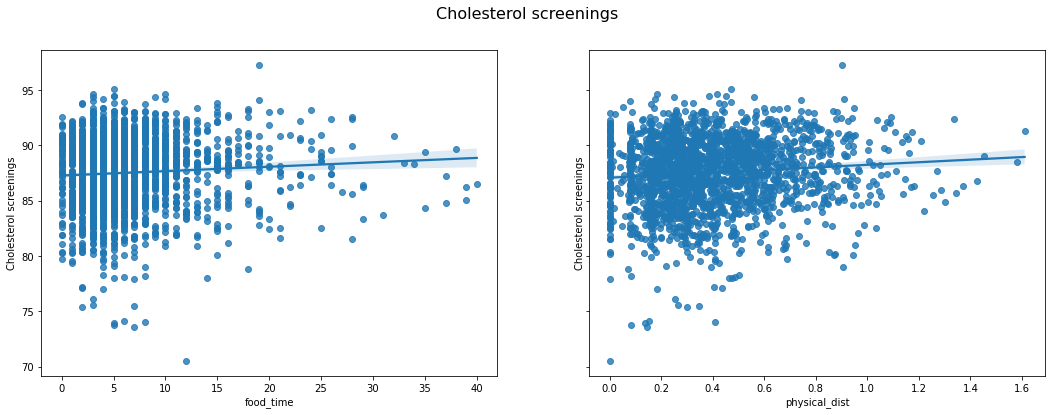

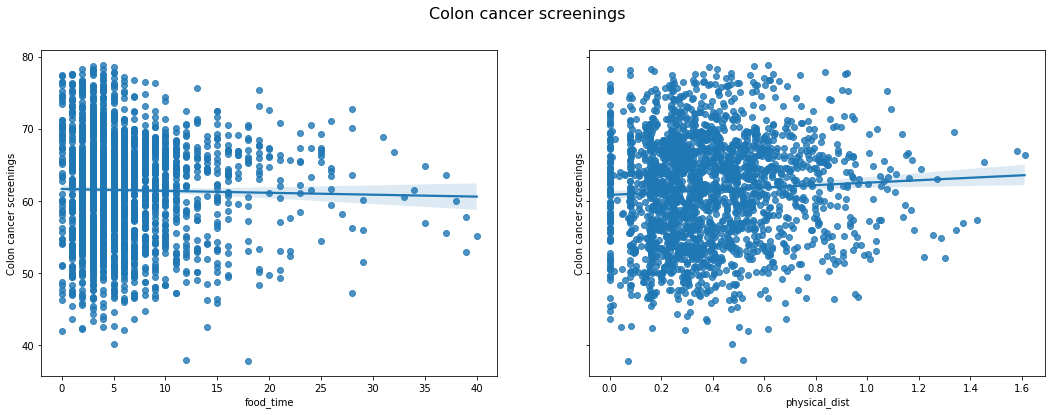

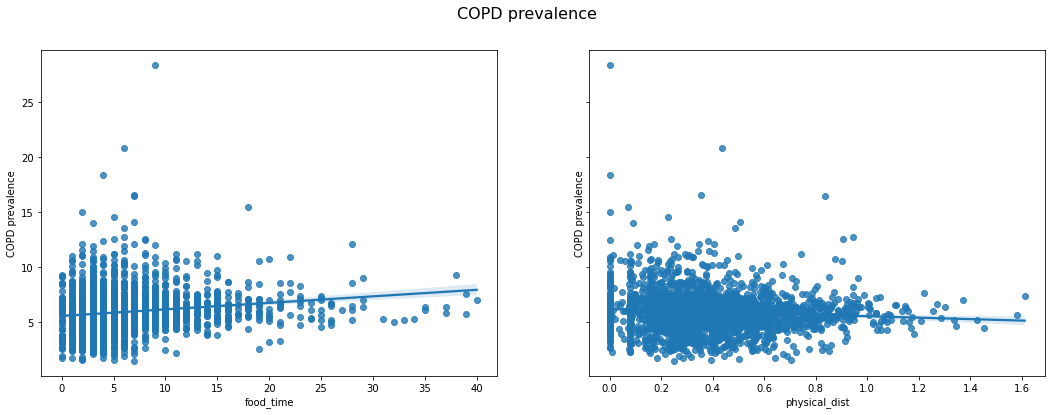

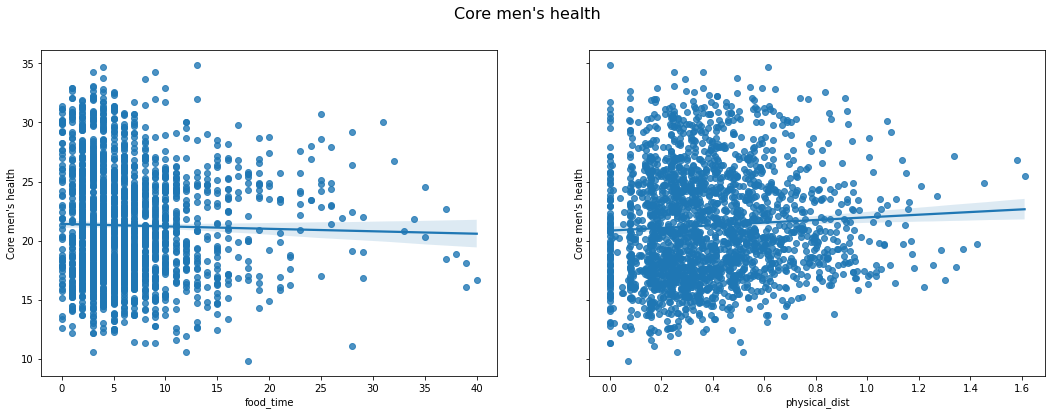

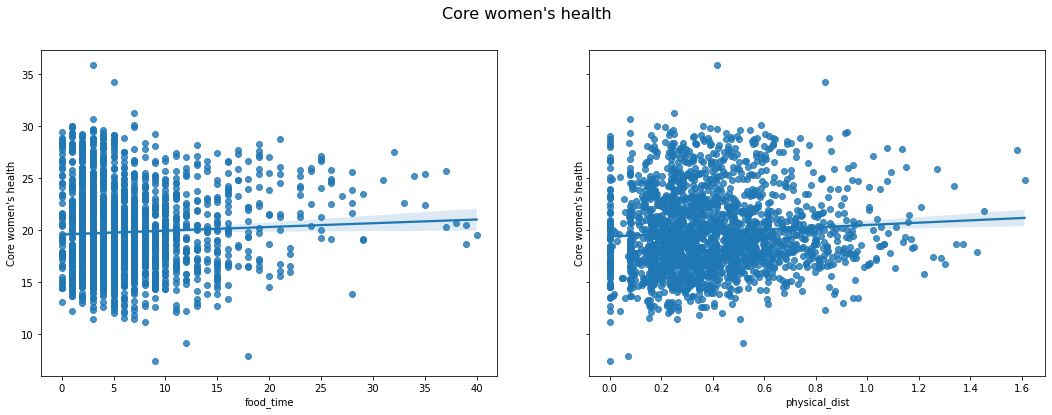

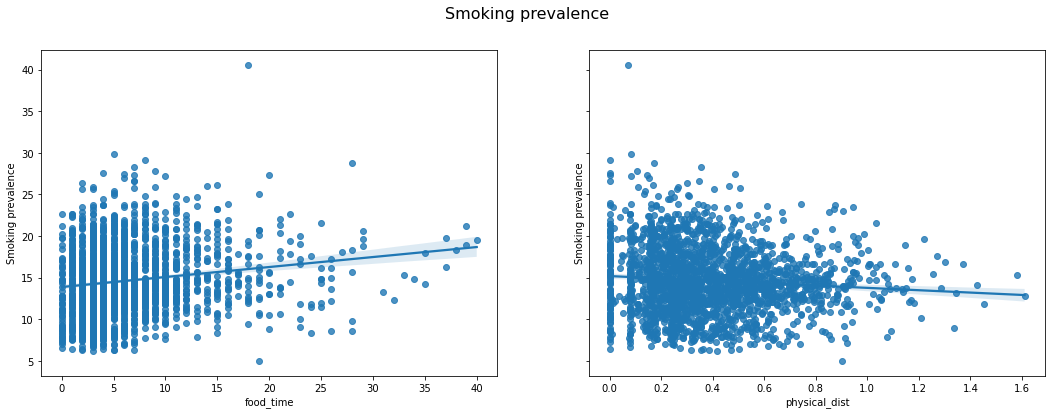

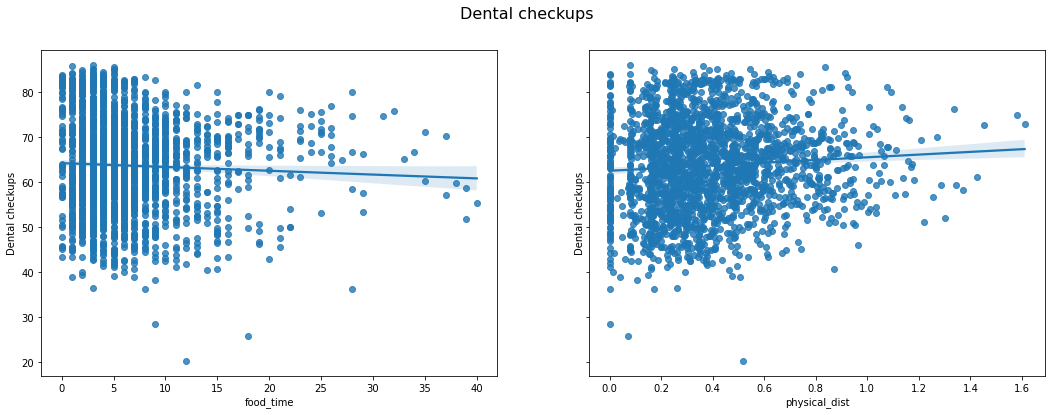

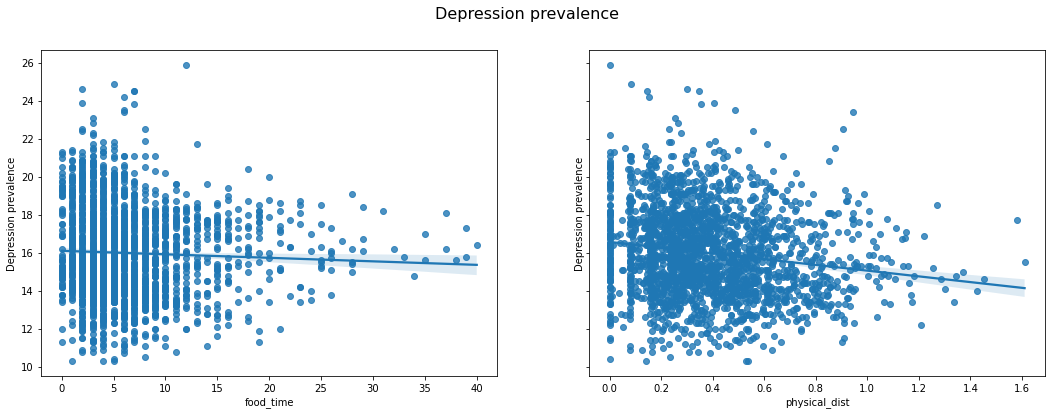

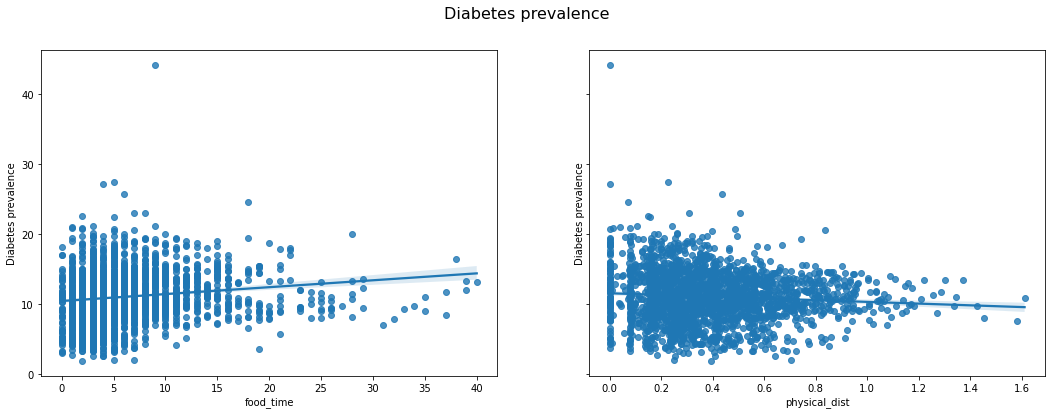

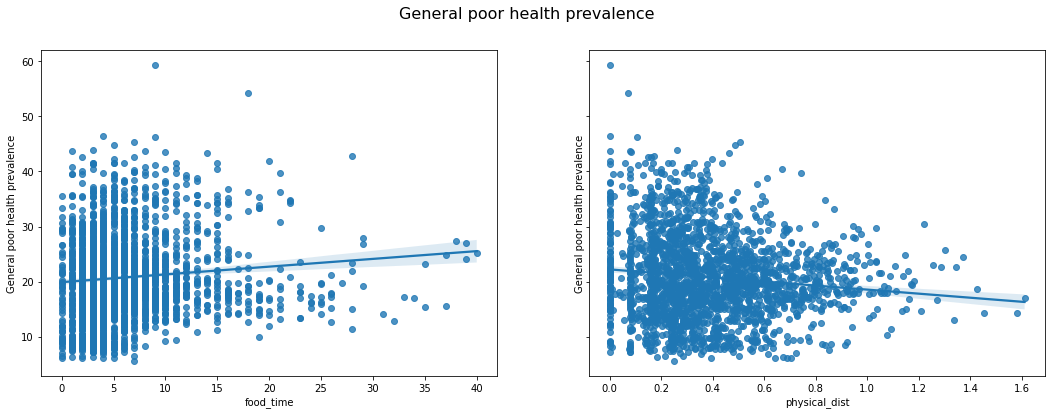

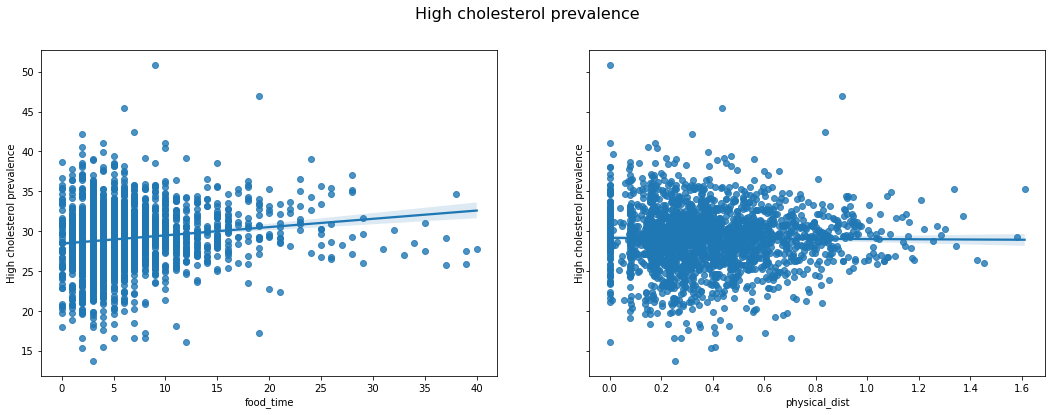

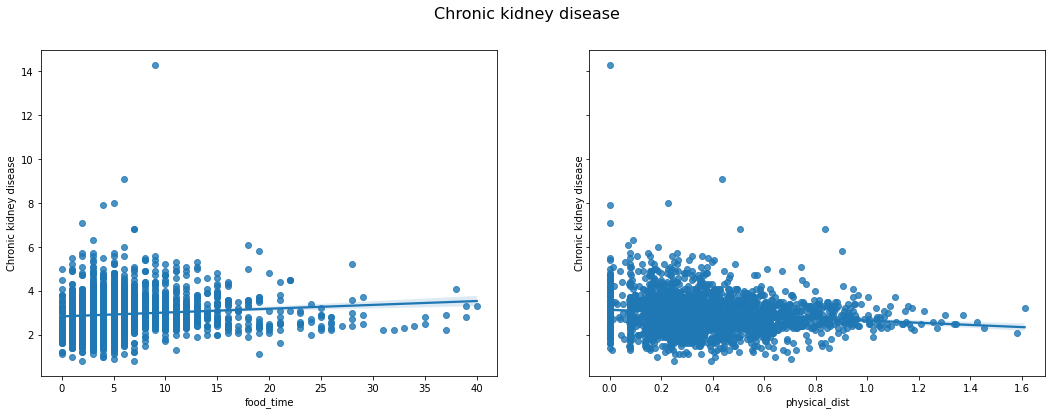

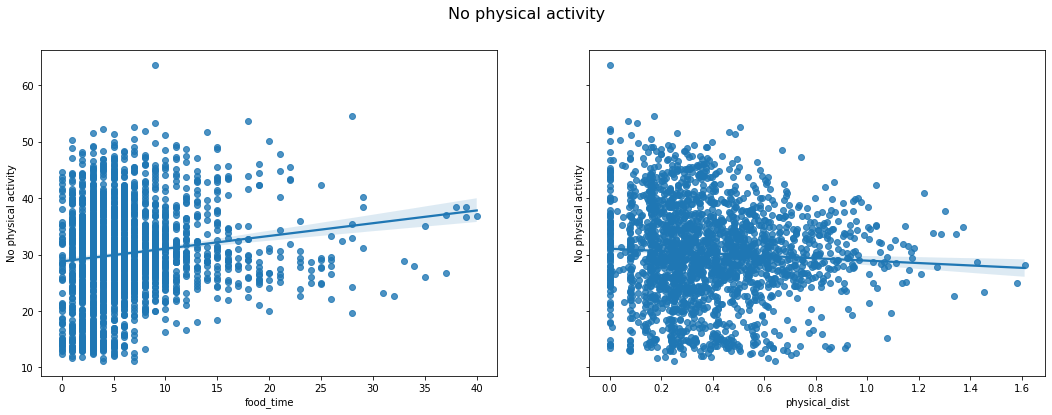

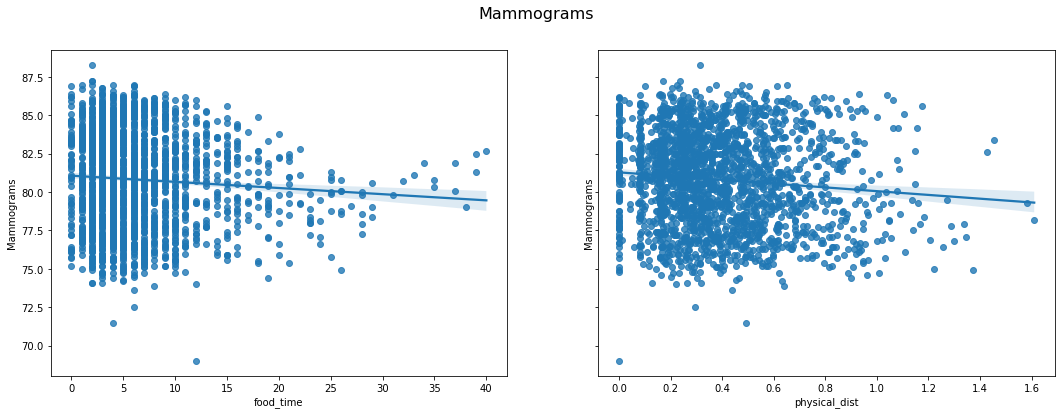

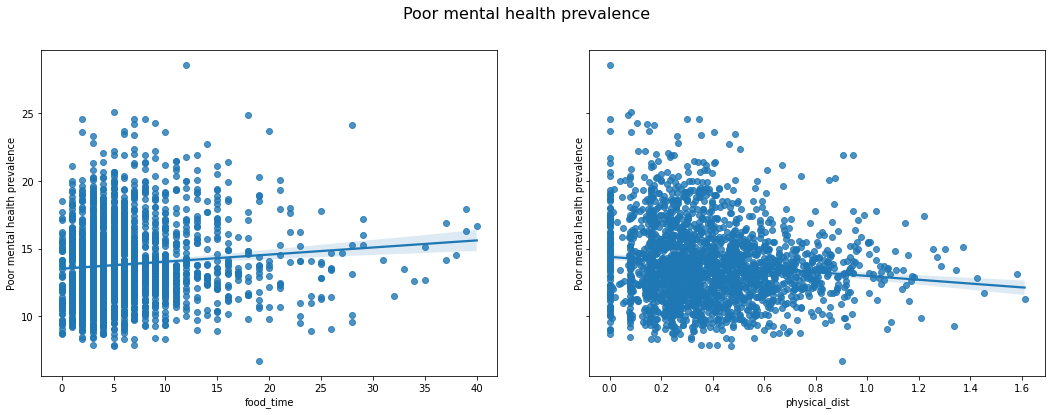

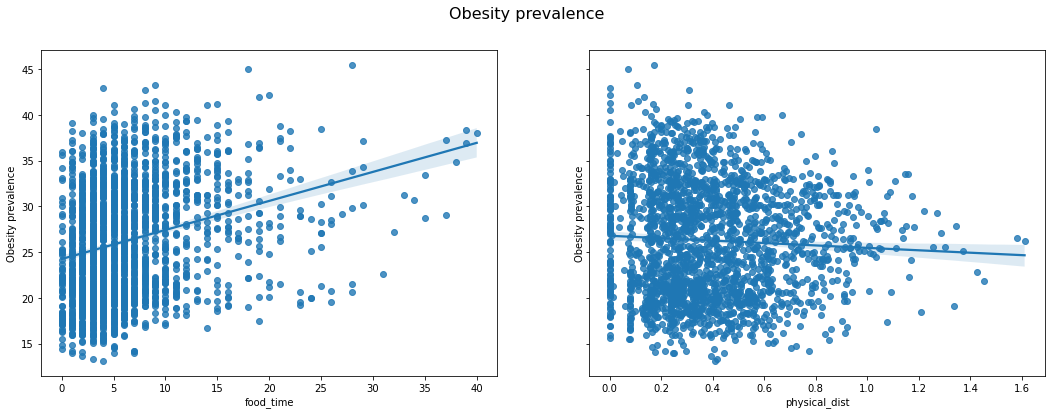

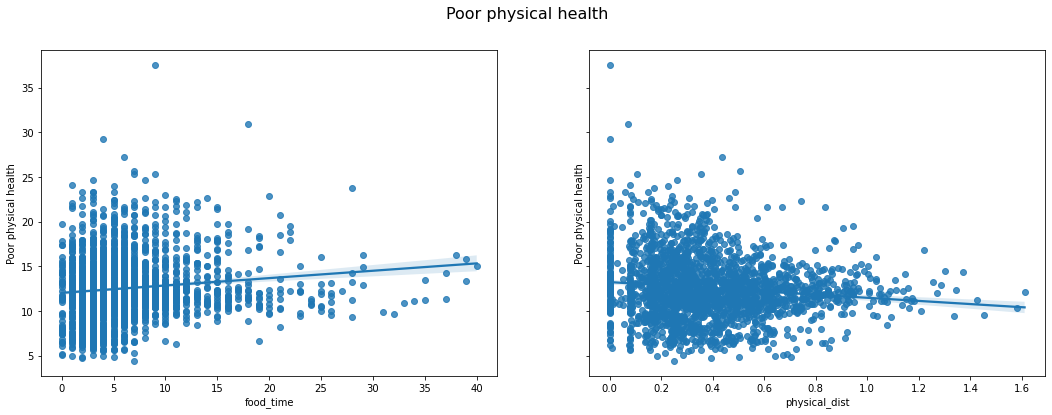

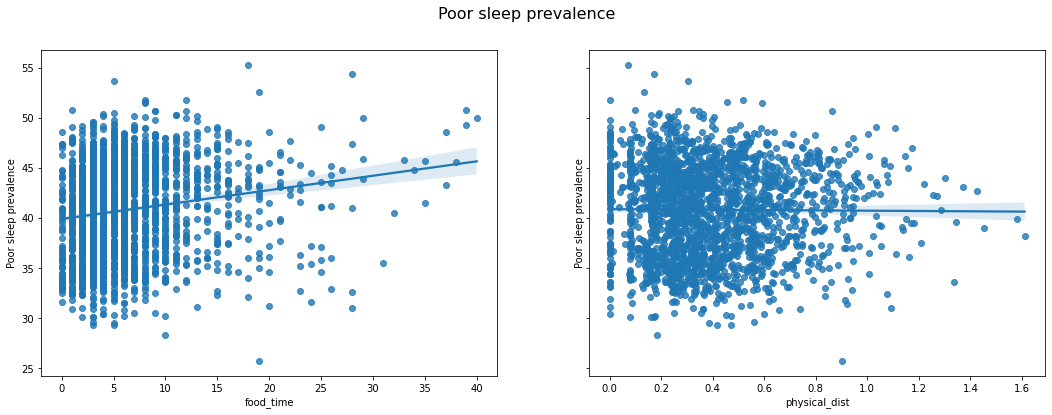

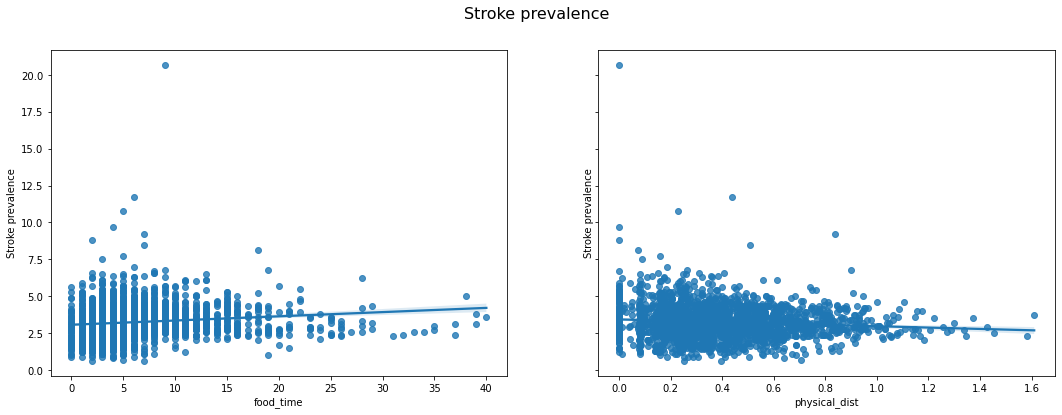

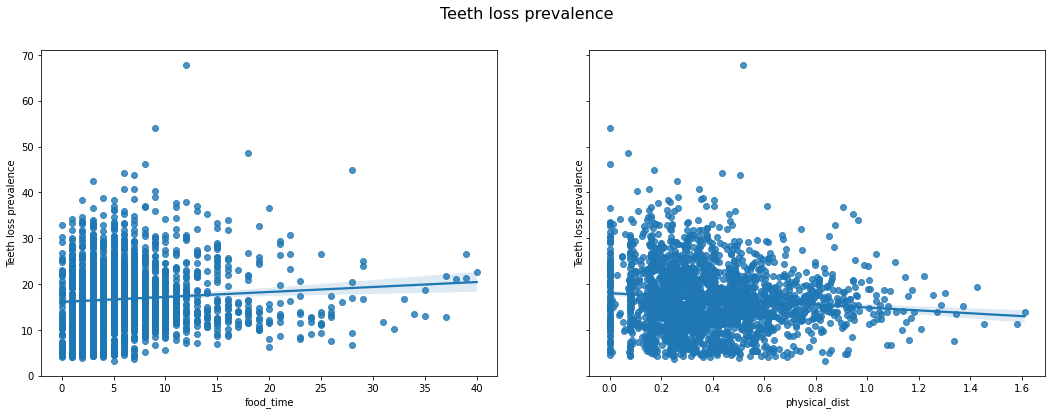

In [22]:
for c in nyc_health.columns:
    if c.endswith('CrudePrev'):
        x = X.copy()
        y = nyc_health[c].to_numpy(copy=True)
        x = x[~np.isnan(y)]
        y = np.reshape(y[~np.isnan(y)], (-1,1))
        arr = np.concatenate((x, y), axis=1)
        df = pd.DataFrame(arr, columns = ["education_time", "food_time","worship_time", "physical_dist", 'transport_dist', 
                                          name_mapping[c[:-10].lower()]])
        fig, axs = plt.subplots(nrows = 1, ncols=2, sharey=True, figsize=(18,6))
        sns.regplot(x="food_time", y=name_mapping[c[:-10].lower()], data=df, ax=axs[0])
        sns.regplot(x="physical_dist", y=name_mapping[c[:-10].lower()], data=df, ax=axs[1])
        fig.suptitle(name_mapping[c[:-10].lower()], fontsize=16)
        plt.show()
        plt.close(fig)

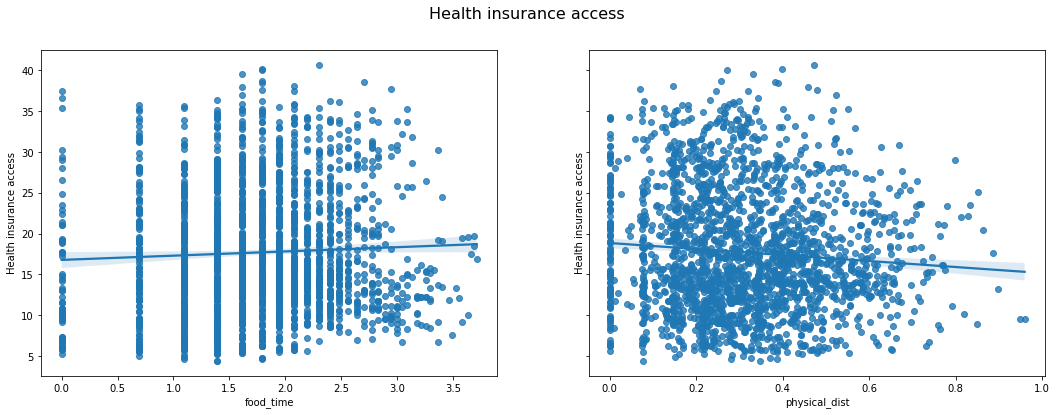

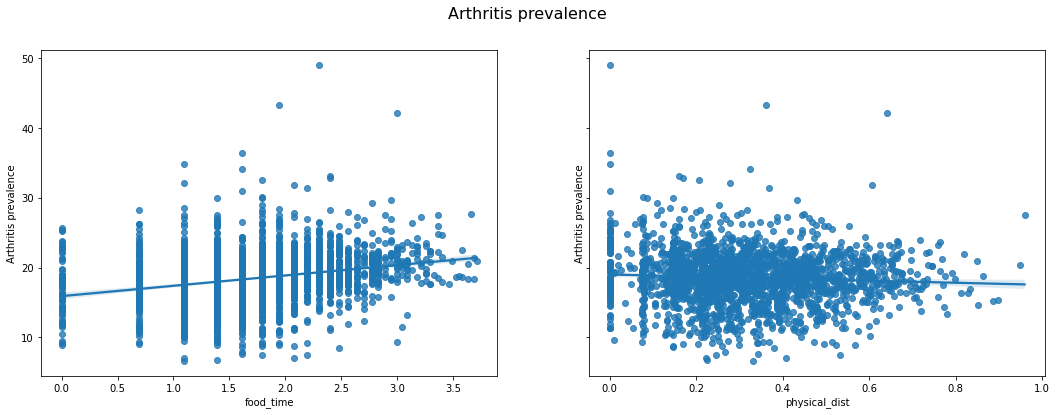

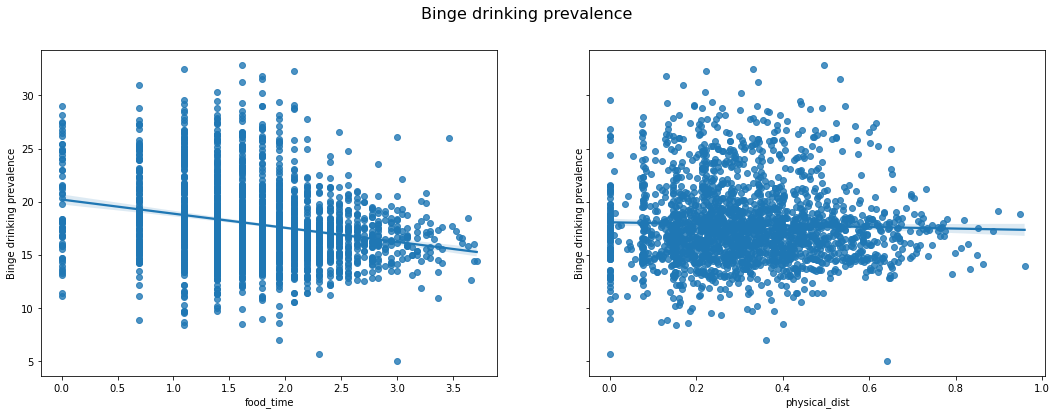

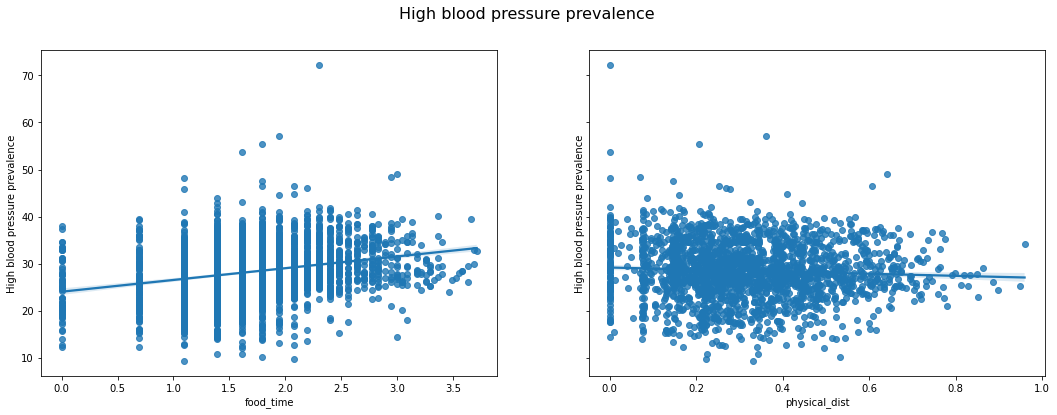

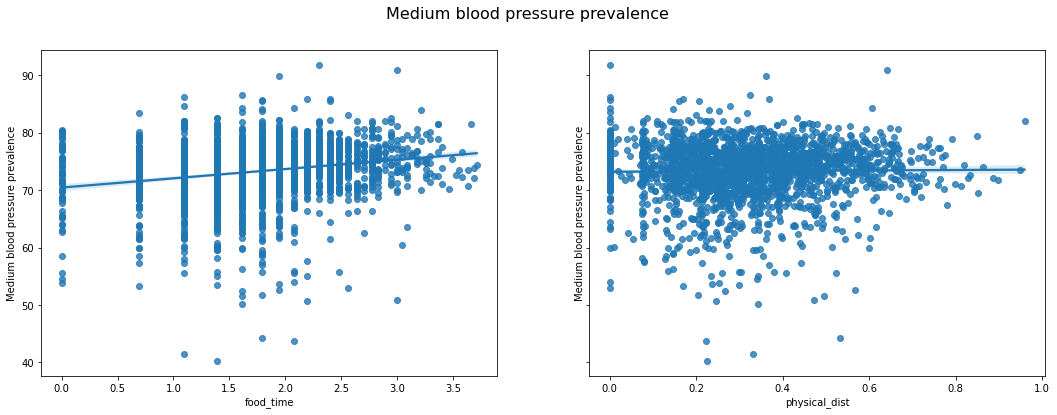

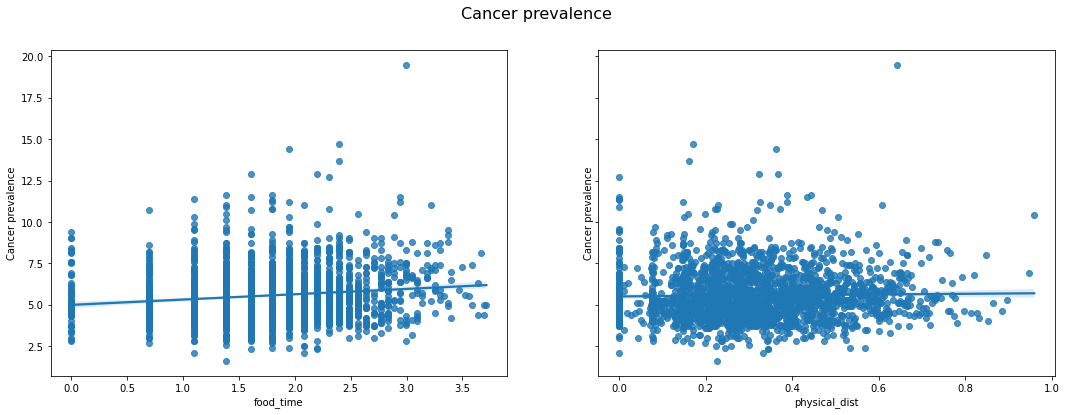

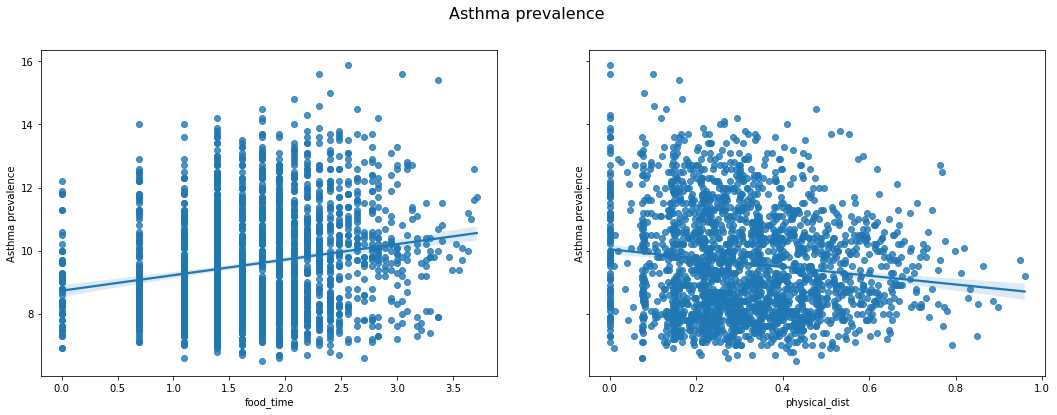

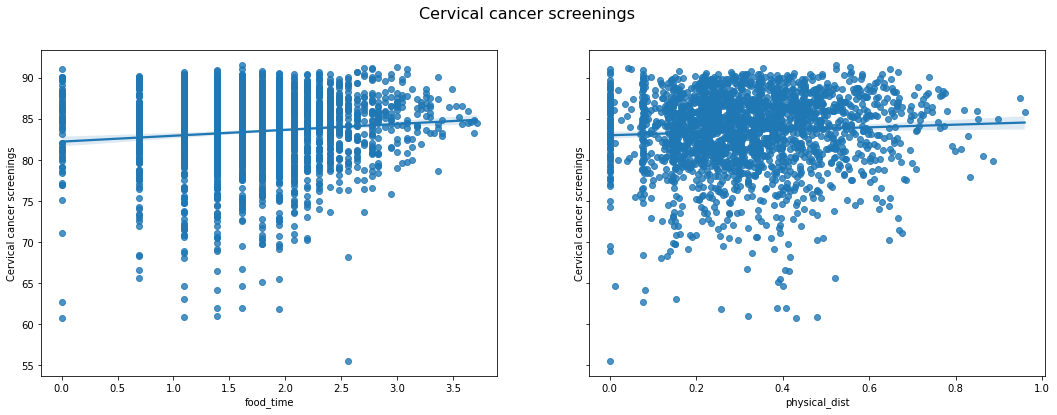

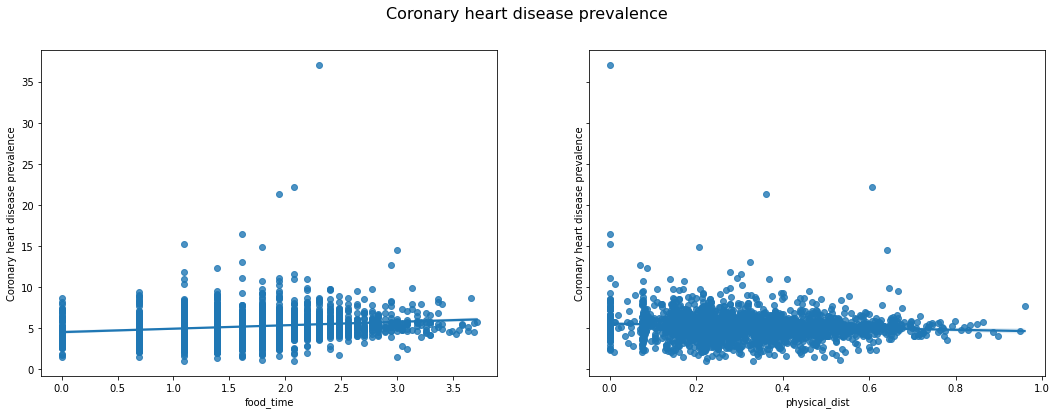

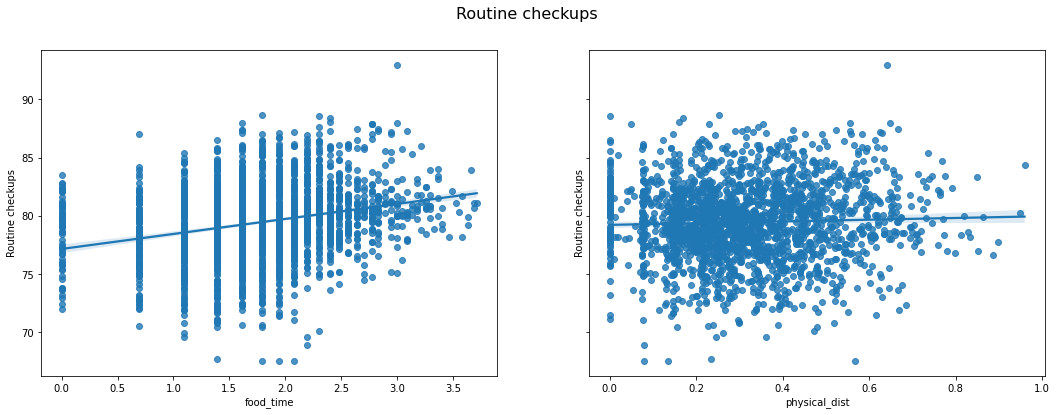

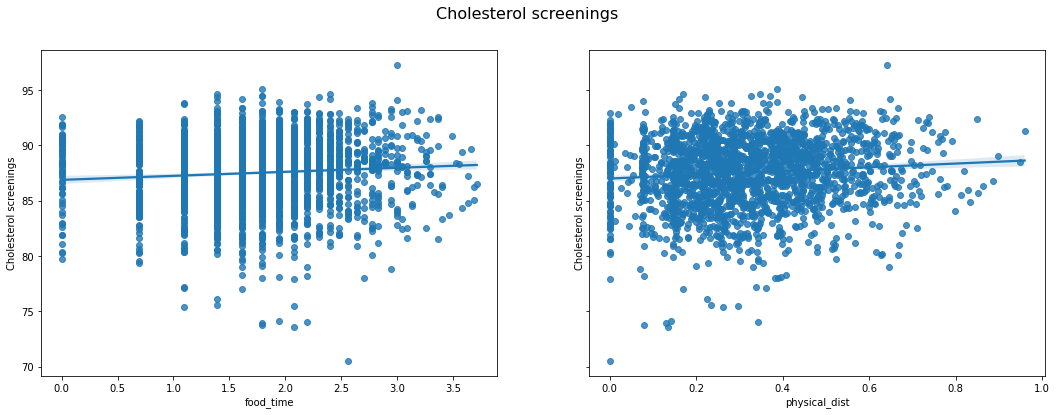

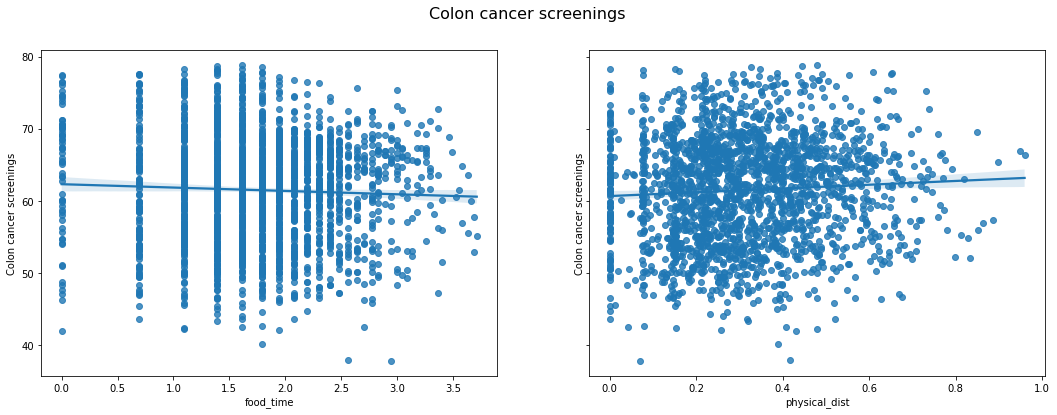

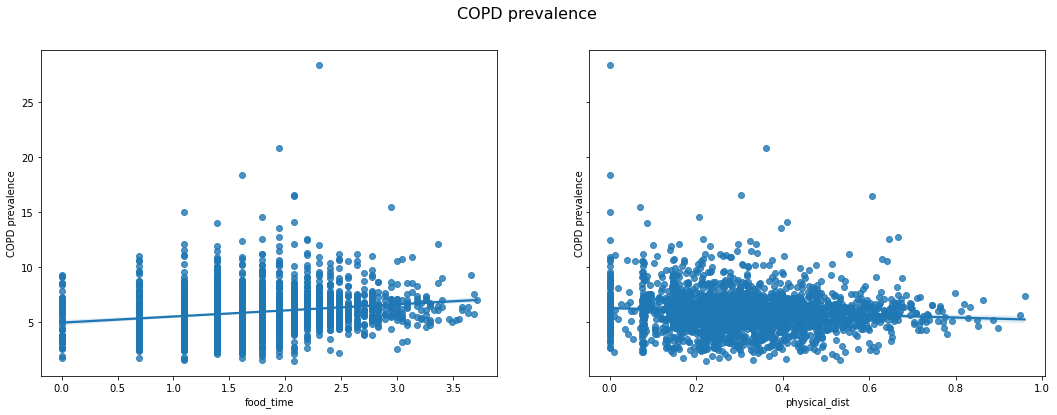

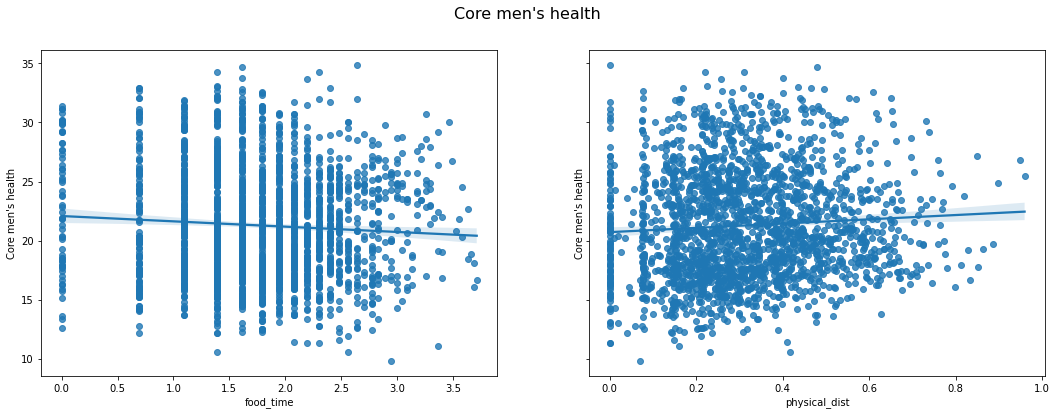

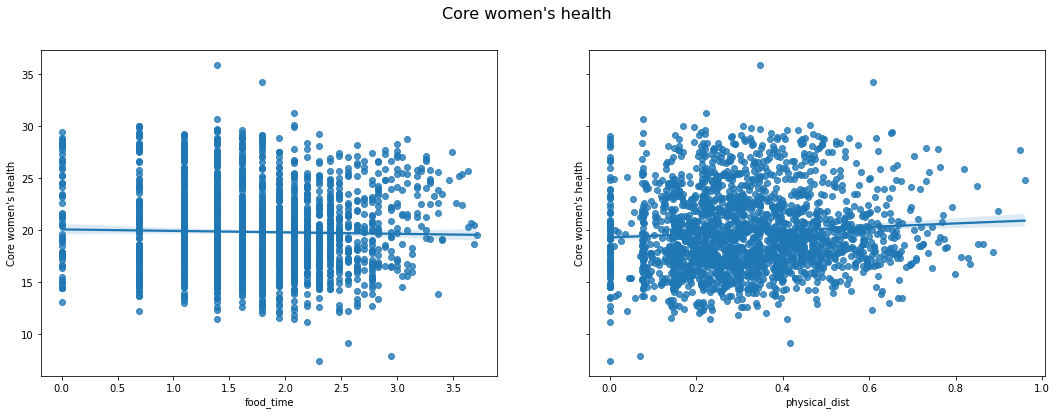

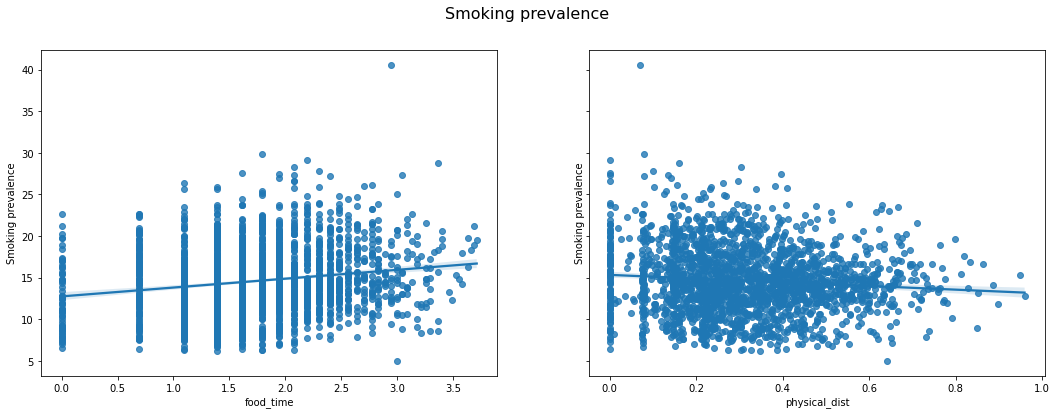

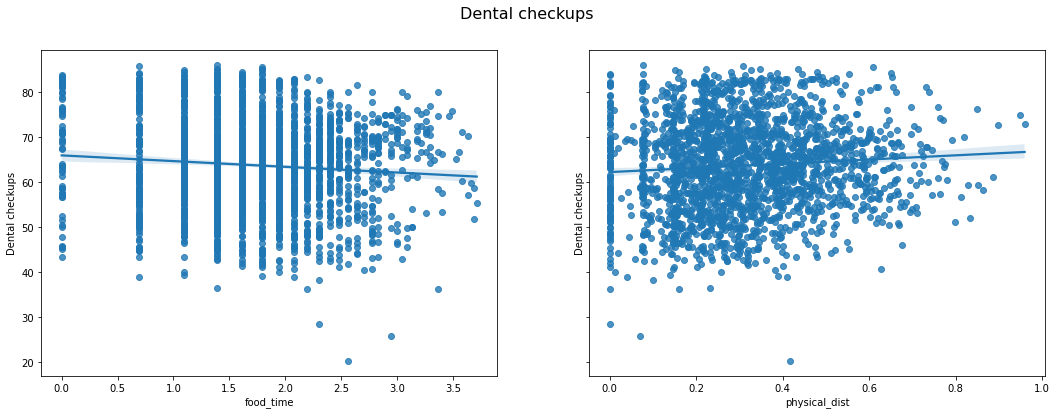

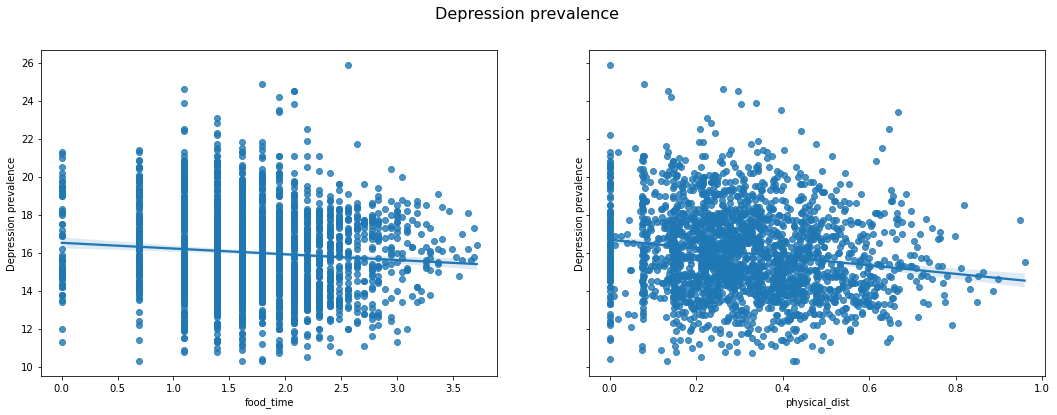

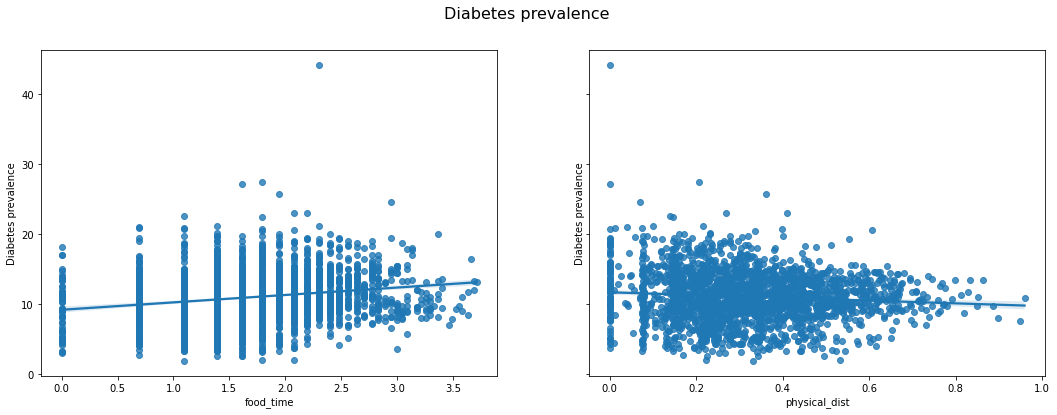

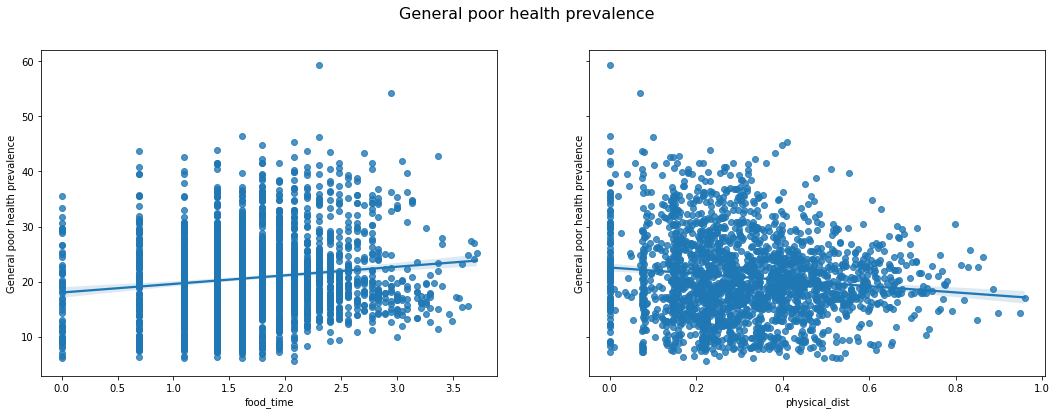

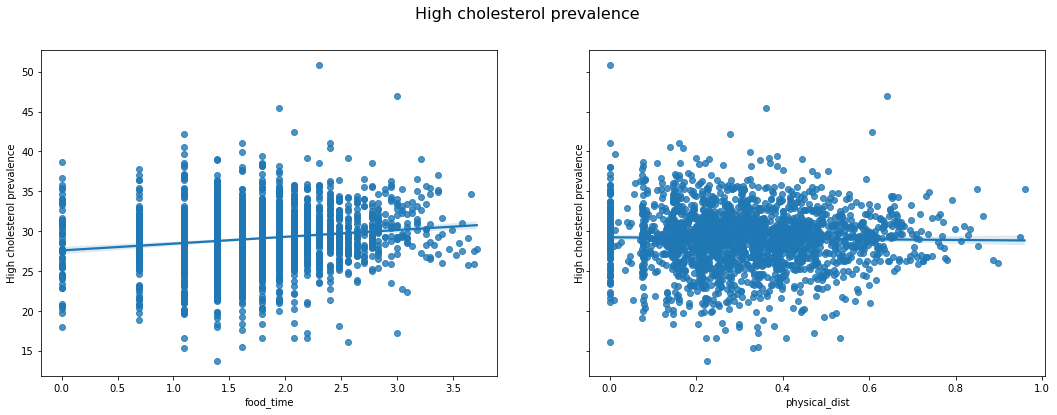

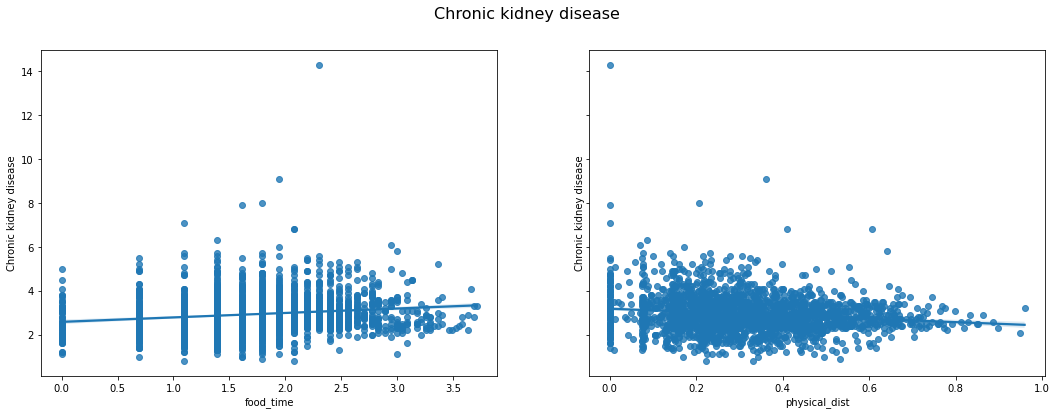

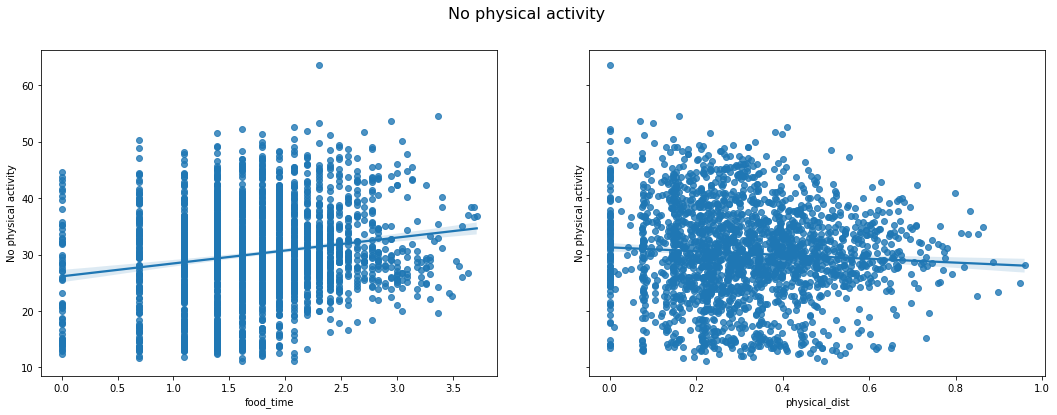

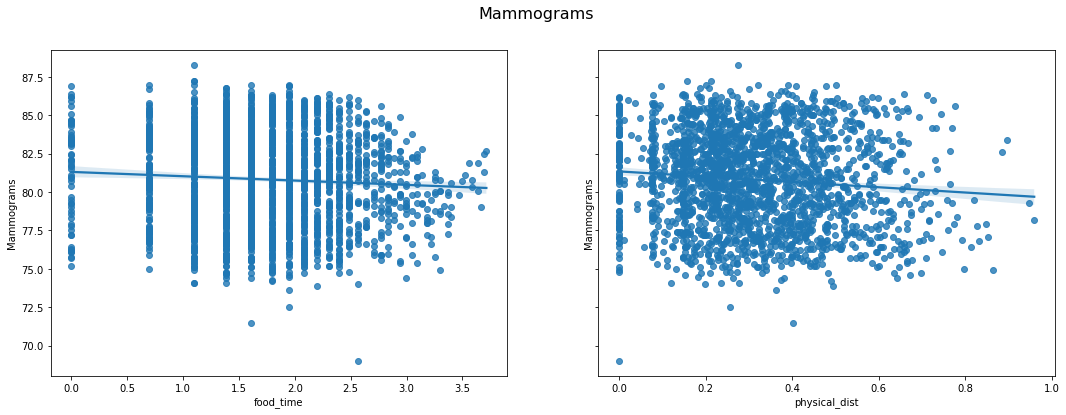

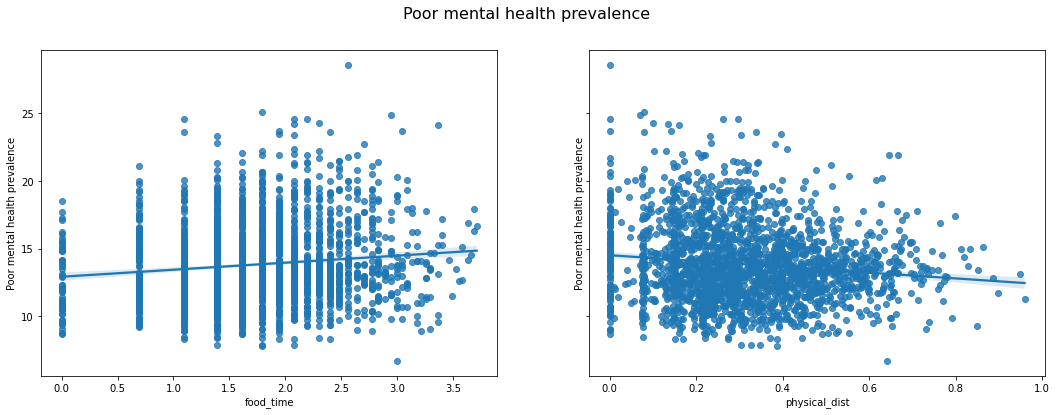

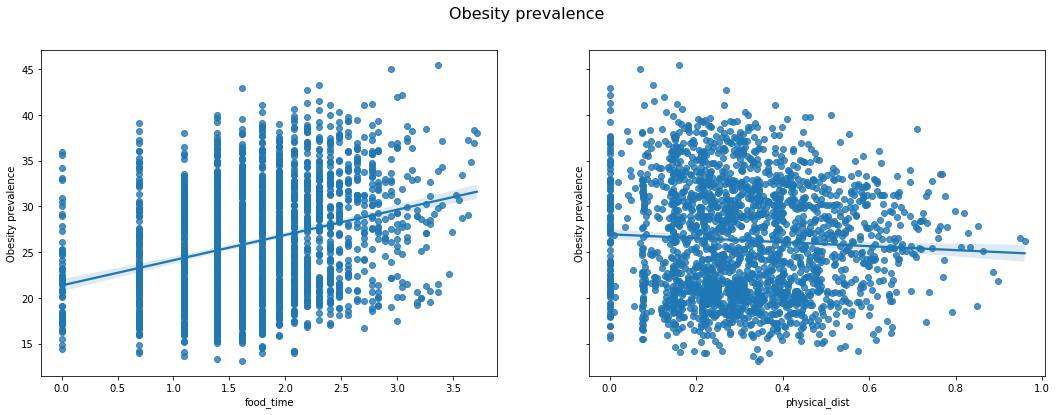

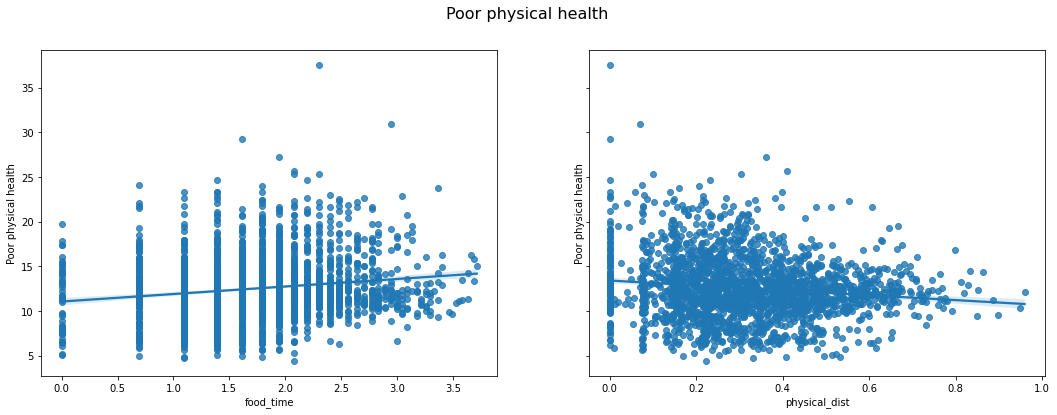

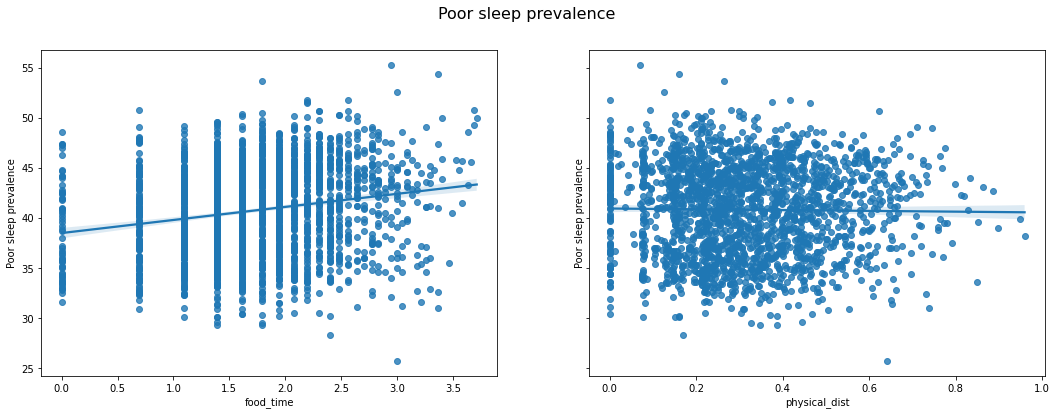

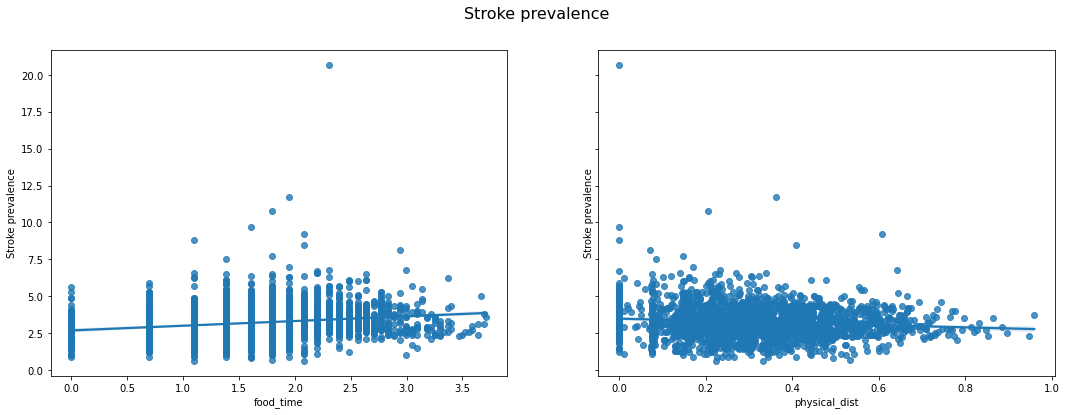

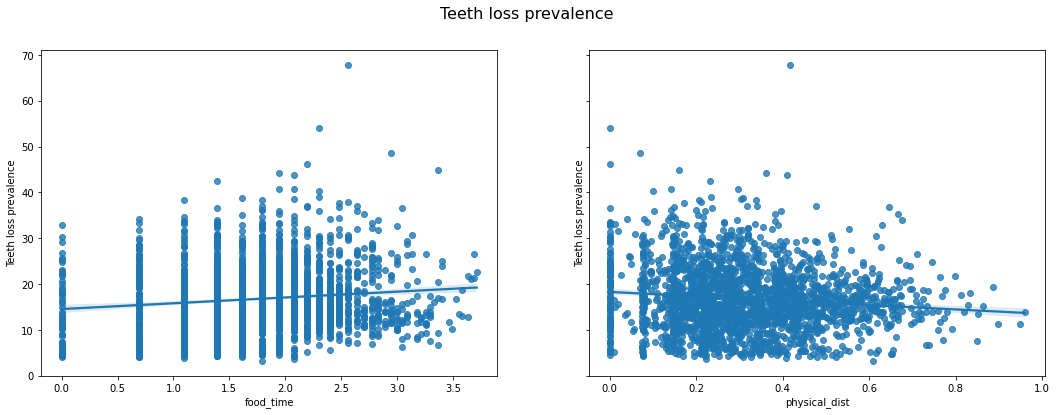

In [25]:
for c in nyc_health.columns:
    if c.endswith('CrudePrev'):
        x = X.copy()
        y = nyc_health[c].to_numpy(copy=True)
        x = np.log(x[~np.isnan(y)]+1)
        y = np.reshape(y[~np.isnan(y)], (-1,1))
        arr = np.concatenate((x, y), axis=1)
        df = pd.DataFrame(arr, columns = ["education_time", "food_time","worship_time", "physical_dist", 'transport_dist', 
                                          name_mapping[c[:-10].lower()]])
        fig, axs = plt.subplots(nrows = 1, ncols=2, sharey=True, figsize=(18,6))
        sns.regplot(x="food_time", y=name_mapping[c[:-10].lower()], data=df, ax=axs[0])
        sns.regplot(x="physical_dist", y=name_mapping[c[:-10].lower()], data=df, ax=axs[1])
        fig.suptitle(name_mapping[c[:-10].lower()], fontsize=16)
        plt.show()
        plt.close(fig)

In [ ]:
deserts = ["Education Travel Time", "Food Travel Time", "Worship Travel Time", "Physical Activity Proximity", 
 "Transportation Proximity"]
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
for col in range(X.shape[1]):
    ax = plt.subplot(2, 3, col + 1)
    ax.hist(X[:, col], bins=50)
    ax.set_title(deserts[col])
plt.tight_layout()
plt.show()

4.0
5.0
4.0
0.34017208218574524
0.3184782564640045


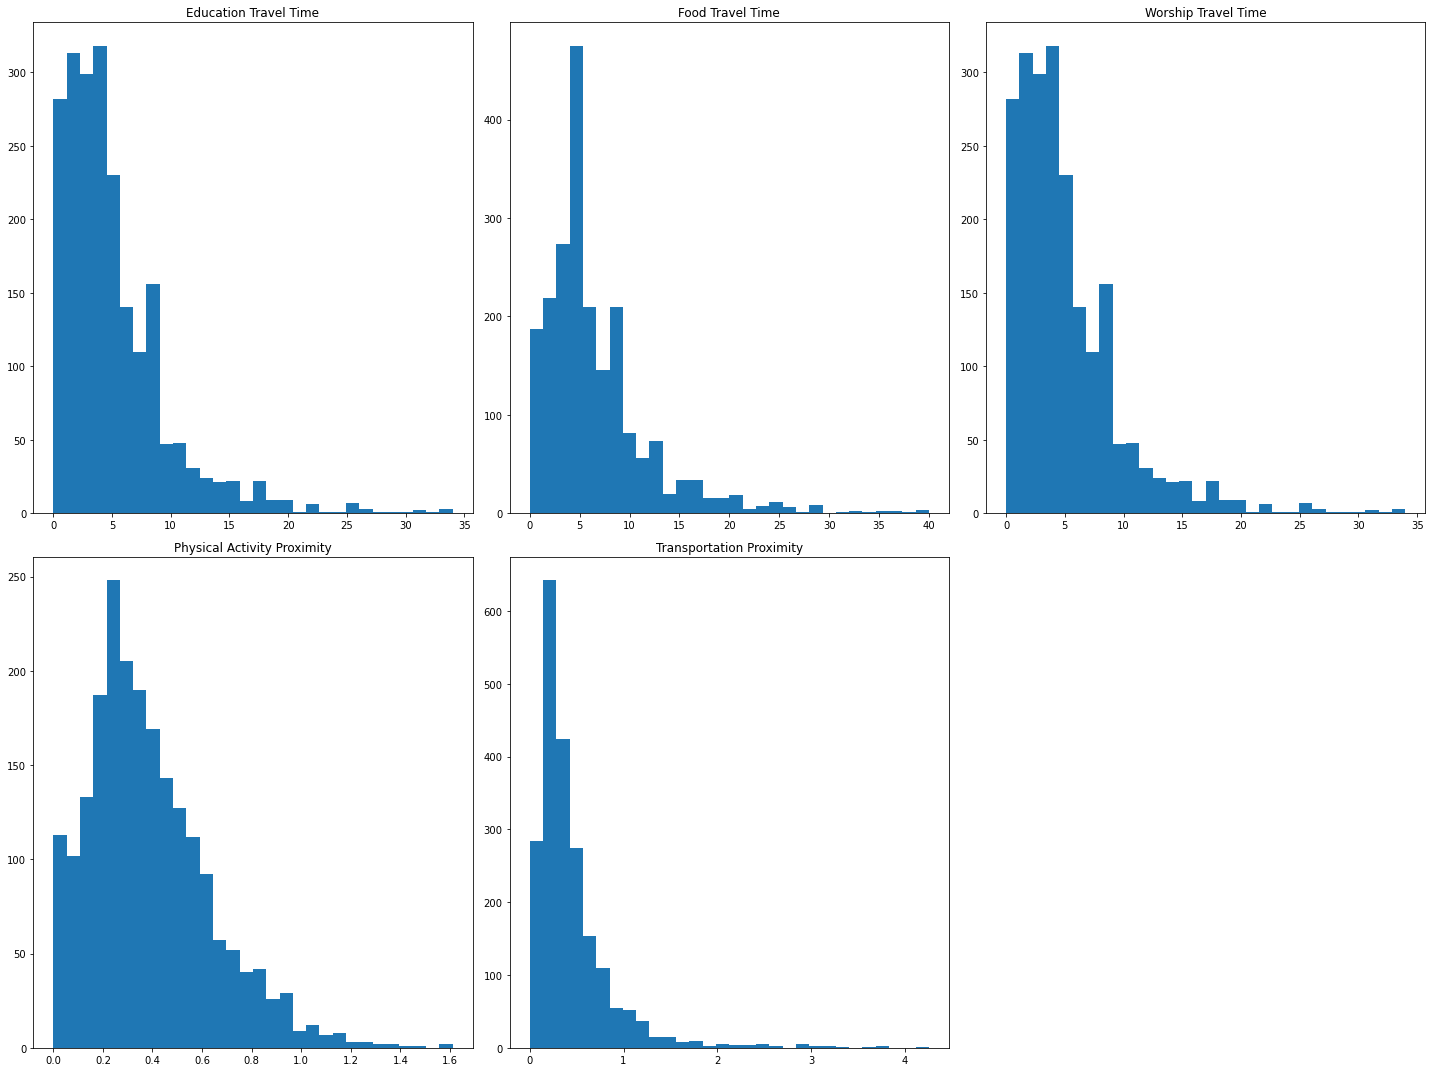

In [57]:
deserts = ["Education Travel Time", "Food Travel Time", "Worship Travel Time", "Physical Activity Proximity", 
 "Transportation Proximity"]
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=0.5)
for col in range(X.shape[1]):
    ax = plt.subplot(2, 3, col + 1)
    ax.hist(X[:, col], bins=30)
    ax.set_title(deserts[col])
for col in desert_measures:
    print(nyc_health[col].median())
plt.tight_layout()
plt.show()

In [ ]:
for c in nyc_health.columns:
    if c.endswith('CrudePrev'):
        y = nyc_health[c].to_numpy(copy=True)
        plt.hist(y, bins=50)
        plt.show()
        plt.close()

In [ ]:
plt.scatter(X[:,0], X[:,1])
plt.show()
print(scipy.stats.pearsonr(X[:,0], X[:,1]) )

In [ ]:
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 
learning_rate = ['constant', 'optimal', 'invscaling'] 
eta0 = [.1, .01, .001, .2] 
param_distributions = dict(penalty=penalty, 
alpha=alpha, 
learning_rate=learning_rate, 
eta0=eta0) 
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV 
for c in nyc_health.columns:
    if c.endswith('CrudePrev'):
        name = name_mapping[c[:-10].lower()]
        
        x = np.log(X.copy()+1)
        mm_scaler = preprocessing.StandardScaler()
        xscale = mm_scaler.fit_transform(x)
        y = nyc_health[c].to_numpy(copy=True)
        x = x[~np.isnan(y)]
        y = y[~np.isnan(y)]
        
        X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.25, 
                                                    random_state=42)
        sgd = SGDRegressor(penalty="l2", max_iter=5)
        random = RandomizedSearchCV(estimator=sgd, 
        param_distributions=param_distributions) 
        random_result = random.fit(X_train, y_train) 
        print('Best Score: ', random_result.best_score_) 
        print('Best Params: ', random_result.best_params_) 